<a href="https://colab.research.google.com/github/Shreenidhi-Kovai-Sivabalan/Accurate-Energy-Demand-Prediction/blob/main/AdvancedModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix A
# Accurate Energy Demand Prediction for Smart Cities using Deep Learning
Project Code

Shreenidhi Kovai Sivabalan

Date of Submission: Oct 1, 2025

# A5. Advanced Models

In [ ]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the raw data to prepare it for LSTMs.
# To ensure deep learning stability and avoid hidden biases due inconsistent preprocessing.
# This is because the preprocessing previously done was ideal for models such as RF, MLP, SVM.
# LSTMs require data in a consistent scale.

filepath = '/content/drive/MyDrive/dissertation/data/household_power_consumption.txt'
data = pd.read_csv(filepath, sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)
data.set_index('Datetime', inplace=True)
data.head()

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [ ]:
# Checking Missing Values
data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Handling Missing Values
data = data.interpolate(method='time')

In [ ]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
# Capping extreme outliers

for col in ['Global_active_power', 'Global_reactive_power']:
  cap_value = data[col].quantile(0.99)
  data[col] = np.where(data[col] > cap_value, cap_value, data[col])

In [ ]:
# Resampling data by hour

data_hourly = data.resample('H').mean()
data_hourly.head()

Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00             3.960500               0.219944  234.643889   
2006-12-16 18:00:00             3.504733               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-16 21:00:00         13.046667             0.0        0.416667   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:00:00       16.861111  
2006-12-16 18:00:00       16.866667  
2006-12-16 19:00:00       16.683333  
2006-12-16 20:00:00       16.783333  
2006-12-16 21:00:00       17.216667

In [ ]:
# Resampling data by day

data_daily = data.resample('D').mean()
data_daily.head()

Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                             
2006-12-16             3.010308               0.087364  236.243763   
2006-12-17             2.333978               0.156692  240.087028   
2006-12-18             1.528854               0.111231  241.231694   
2006-12-19             1.132260               0.104237  241.999313   
2006-12-20             1.535765               0.111800  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361        0.000000        1.838889        9.765972

In [ ]:
# Scaling the data using MinMax Scaler because for LSTMs the feature values have to fall between [0, 1]

from sklearn.preprocessing import MinMaxScaler

def scale_data(df):
  scaler = MinMaxScaler()
  df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
  return df_scaled

In [ ]:
data_min_scaled = scale_data(data)
data_hr_scaled = scale_data(data_hourly)
data_dy_scaled = scale_data(data_daily)

In [ ]:
data_min_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:24:00             0.869383               0.878151  0.376090   
2006-12-16 17:25:00             1.000000               0.915966  0.336995   
2006-12-16 17:26:00             1.000000               1.000000  0.326010   
2006-12-16 17:27:00             1.000000               1.000000  0.340549   
2006-12-16 17:28:00             0.753885               1.000000  0.403231   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00          0.377593             0.0          0.0125   
2006-12-16 17:25:00          0.473029             0.0          0.0125   
2006-12-16 17:26:00          0.473029             0.0          0.0250   
2006-12-16 17:27:00          0.473029             0.0          0.0125   
2006-12-16 17:28:00          0.323651             0.0          0.0125   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00        0.548387  
2006-12-16 17:25:00        0.516129  
2006-12-16 17:26:00        0.548387  
2006-12-16 17:27:00        0.548387  
2006-12-16 17:28:00        0.548387

In [ ]:
data_hr_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:00:00             0.814774               0.462068  0.337945   
2006-12-16 18:00:00             0.717981               0.168137  0.335501   
2006-12-16 19:00:00             0.695788               0.179062  0.283802   
2006-12-16 20:00:00             0.667825               0.157773  0.315987   
2006-12-16 21:00:00             0.622781               0.161064  0.434417   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00          0.631157             0.0        0.011366   
2006-12-16 18:00:00          0.541487             0.0        0.144652   
2006-12-16 19:00:00          0.502152             0.0        0.030869   
2006-12-16 20:00:00          0.481110             0.0        0.000000   
2006-12-16 21:00:00          0.449904             0.0        0.008973   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:00:00        0.687521  
2006-12-16 18:00:00        0.687748  
2006-12-16 19:00:00        0.680272  
2006-12-16 20:00:00        0.684350  
2006-12-16 21:00:00        0.702019

In [ ]:
data_dy_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                           
2006-12-16             0.937993               0.267969  0.315385   
2006-12-17             0.714339               0.532628  0.550494   
2006-12-18             0.448094               0.359081  0.620518   
2006-12-19             0.316945               0.332385  0.667476   
2006-12-20             0.450380               0.361255  0.686364   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                                                      
2006-12-16          0.928499        0.000000        0.163965        0.754442  
2006-12-17          0.695226        0.181130        0.345776        0.561892  
2006-12-18          0.424618        0.094708        0.216451        0.590406  
2006-12-19          0.311508        0.074751        0.627798        0.261003  
2006-12-20          0.428075        0.000000        0.218680        0.592301

In [ ]:
# Feature Engineering of Time-based features


import holidays

def time_based_feat(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['year'] = df.index.year
  return df

def seasons(df):
  def get_season(month):
    if month in [12, 1, 2]:
      return 'Winter'
    elif month in [3, 4, 5]:
      return 'Spring'
    elif month in [6, 7, 8]:
      return 'Summer'
    else:
      return 'Autumn'
  df['season'] = df['month'].apply(get_season)
  df = pd.get_dummies(df, columns=['season'], drop_first=True)
  # Convert boolean columns to integer
  for col in ['season_Spring', 'season_Summer', 'season_Winter']:
    if col in df.columns:
      df[col] = df[col].astype(int)
  return df

def holiday(df):
  france_holidays = holidays.France()
  df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in france_holidays else 0)
  return df

In [ ]:
# Applying the feature engineering functions to all data frequencies

data_min_scaled = time_based_feat(data_min_scaled)
data_min_scaled = seasons(data_min_scaled)
data_min_scaled = holiday(data_min_scaled)
data_hr_scaled = time_based_feat(data_hr_scaled)
data_hr_scaled = seasons(data_hr_scaled)
data_hr_scaled = holiday(data_hr_scaled)
data_dy_scaled = time_based_feat(data_dy_scaled)
data_dy_scaled = seasons(data_dy_scaled)
data_dy_scaled = holiday(data_dy_scaled)

In [ ]:
data_min_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:24:00             0.869383               0.878151  0.376090   
2006-12-16 17:25:00             1.000000               0.915966  0.336995   
2006-12-16 17:26:00             1.000000               1.000000  0.326010   
2006-12-16 17:27:00             1.000000               1.000000  0.340549   
2006-12-16 17:28:00             0.753885               1.000000  0.403231   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00          0.377593             0.0          0.0125   
2006-12-16 17:25:00          0.473029             0.0          0.0125   
2006-12-16 17:26:00          0.473029             0.0          0.0250   
2006-12-16 17:27:00          0.473029             0.0          0.0125   
2006-12-16 17:28:00          0.323651             0.0          0.0125   

                     Sub_metering_3  hour  dayofweek  month  year  \
Datetime                                                            
2006-12-16 17:24:00        0.548387    17          5     12  2006   
2006-12-16 17:25:00        0.516129    17          5     12  2006   
2006-12-16 17:26:00        0.548387    17          5     12  2006   
2006-12-16 17:27:00        0.548387    17          5     12  2006   
2006-12-16 17:28:00        0.548387    17          5     12  2006   

                     season_Spring  season_Summer  season_Winter  is_holiday  
Datetime                                                                      
2006-12-16 17:24:00              0              0              1           0  
2006-12-16 17:25:00              0              0              1           0  
2006-12-16 17:26:00              0              0              1           0  
2006-12-16 17:27:00              0              0              1           0  
2006-12-16 17:28:00              0              0              1           0

In [ ]:
data_hr_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:00:00             0.814774               0.462068  0.337945   
2006-12-16 18:00:00             0.717981               0.168137  0.335501   
2006-12-16 19:00:00             0.695788               0.179062  0.283802   
2006-12-16 20:00:00             0.667825               0.157773  0.315987   
2006-12-16 21:00:00             0.622781               0.161064  0.434417   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00          0.631157             0.0        0.011366   
2006-12-16 18:00:00          0.541487             0.0        0.144652   
2006-12-16 19:00:00          0.502152             0.0        0.030869   
2006-12-16 20:00:00          0.481110             0.0        0.000000   
2006-12-16 21:00:00          0.449904             0.0        0.008973   

                     Sub_metering_3  hour  dayofweek  month  year  \
Datetime                                                            
2006-12-16 17:00:00        0.687521    17          5     12  2006   
2006-12-16 18:00:00        0.687748    18          5     12  2006   
2006-12-16 19:00:00        0.680272    19          5     12  2006   
2006-12-16 20:00:00        0.684350    20          5     12  2006   
2006-12-16 21:00:00        0.702019    21          5     12  2006   

                     season_Spring  season_Summer  season_Winter  is_holiday  
Datetime                                                                      
2006-12-16 17:00:00              0              0              1           0  
2006-12-16 18:00:00              0              0              1           0  
2006-12-16 19:00:00              0              0              1           0  
2006-12-16 20:00:00              0              0              1           0  
2006-12-16 21:00:00              0              0              1           0

In [ ]:
data_dy_scaled.head()

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                           
2006-12-16             0.937993               0.267969  0.315385   
2006-12-17             0.714339               0.532628  0.550494   
2006-12-18             0.448094               0.359081  0.620518   
2006-12-19             0.316945               0.332385  0.667476   
2006-12-20             0.450380               0.361255  0.686364   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2006-12-16          0.928499        0.000000        0.163965        0.754442   
2006-12-17          0.695226        0.181130        0.345776        0.561892   
2006-12-18          0.424618        0.094708        0.216451        0.590406   
2006-12-19          0.311508        0.074751        0.627798        0.261003   
2006-12-20          0.428075        0.000000        0.218680        0.592301   

            hour  dayofweek  month  year  season_Spring  season_Summer  \
Datetime                                                                 
2006-12-16     0          5     12  2006              0              0   
2006-12-17     0          6     12  2006              0              0   
2006-12-18     0          0     12  2006              0              0   
2006-12-19     0          1     12  2006              0              0   
2006-12-20     0          2     12  2006              0              0   

            season_Winter  is_holiday  
Datetime                               
2006-12-16              1           0  
2006-12-17              1           0  
2006-12-18              1           0  
2006-12-19              1           0  
2006-12-20              1           0

In [ ]:
# Feature engineering lag and rolling features

# Lag features for minute level data
# Example Lags: 1 hour, 1 day, 1 week
lags_min = [60, 1440, 10080] # 1 hr, 1 month and 1 week in minutes respectively
for lag in lags_min:
  data_min_scaled[f'Global_active_power_lag_{lag}'] = data_min_scaled['Global_active_power'].shift(lag)


# Rolling Window Statistics for minute data
# Example Windows: 1 days, 7days (in minutes)
windows_min = [1440, 10080] # 1 day and 7 days in minutes respectively
for window in windows_min:
  data_min_scaled[f'GAP_rolling_mean_{window}'] = data_min_scaled['Global_active_power'].rolling(window=window).mean()
  data_min_scaled[f'GAP_rolling_std_{window}'] = data_min_scaled['Global_active_power'].rolling(window=window).std()
  data_min_scaled[f'GAP_rolling_max_{window}'] = data_min_scaled['Global_active_power'].rolling(window=window).max()

data_min_scaled.dropna(inplace=True)

# Lag Features for hourly data
lags_hr = [1, 24, 168]
for lag in lags_hr:
  data_hr_scaled[f'Global_active_power_lag_{lag}'] = data_hr_scaled['Global_active_power'].shift(lag)

# Rolling Window Statistics for hourly data
windows_hr = [24, 168]
for window in windows_hr:
  data_hr_scaled[f'GAP_rolling_mean_{window}'] = data_hr_scaled['Global_active_power'].rolling(window=window).mean()
  data_hr_scaled[f'GAP_rolling_std_{window}'] = data_hr_scaled['Global_active_power'].rolling(window=window).std()
  data_hr_scaled[f'GAP_rolling_max_{window}'] = data_hr_scaled['Global_active_power'].rolling(window=window).max()

data_hr_scaled.dropna(inplace=True)

# Lag Features for daily data
lags_dly = [1, 7, 30]
for lag in lags_dly:
  data_dy_scaled[f'Global_active_power_lag_{lag}'] = data_dy_scaled['Global_active_power'].shift(lag)

# Rolling Window Statistics for daily data
windows_dly = [7, 30]
for window in windows_dly:
  data_dy_scaled[f'GAP_rolling_mean_{window}'] = data_dy_scaled['Global_active_power'].rolling(window=window).mean()
  data_dy_scaled[f'GAP_rolling_std_{window}'] = data_dy_scaled['Global_active_power'].rolling(window=window).std()
  data_dy_scaled[f'GAP_rolling_max_{window}'] = data_dy_scaled['Global_active_power'].rolling(window=window).max()

data_dy_scaled.dropna(inplace=True)

In [ ]:
data_min_scaled.head(2)

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-23 17:24:00              0.99706               0.289916  0.273667   
2006-12-23 17:25:00              0.99664               0.289916  0.277221   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-23 17:24:00          0.427386        0.011364          0.0125   
2006-12-23 17:25:00          0.427386        0.022727          0.0250   

                     Sub_metering_3  hour  dayofweek  month  ...  is_holiday  \
Datetime                                                     ...               
2006-12-23 17:24:00        0.516129    17          5     12  ...           0   
2006-12-23 17:25:00        0.548387    17          5     12  ...           0   

                     Global_active_power_lag_60  Global_active_power_lag_1440  \
Datetime                                                                        
2006-12-23 17:24:00                    0.865603                      0.377152   
2006-12-23 17:25:00                    0.556069                      0.375052   

                     Global_active_power_lag_10080  GAP_rolling_mean_1440  \
Datetime                                                                    
2006-12-23 17:24:00                       0.869383               0.601355   
2006-12-23 17:25:00                       1.000000               0.601786   

                     GAP_rolling_std_1440  GAP_rolling_max_1440  \
Datetime                                                          
2006-12-23 17:24:00              0.263321                   1.0   
2006-12-23 17:25:00              0.263459                   1.0   

                     GAP_rolling_mean_10080  GAP_rolling_std_10080  \
Datetime                                                             
2006-12-23 17:24:00                0.351179               0.274803   
2006-12-23 17:25:00                0.351179               0.274802   

                     GAP_rolling_max_10080  
Datetime                                    
2006-12-23 17:24:00                    1.0  
2006-12-23 17:25:00                    1.0  

[2 rows x 24 columns]

In [ ]:
data_hr_scaled.head(2)

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-23 17:00:00             0.962155               0.453711  0.299594   
2006-12-23 18:00:00             0.790280               0.209594  0.466711   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-23 17:00:00          0.819823        0.334597        0.014358   
2006-12-23 18:00:00          0.568867        0.000000        0.000359   

                     Sub_metering_3  hour  dayofweek  month  ...  is_holiday  \
Datetime                                                     ...               
2006-12-23 17:00:00        0.682990    17          5     12  ...           0   
2006-12-23 18:00:00        0.707456    18          5     12  ...           0   

                     Global_active_power_lag_1  Global_active_power_lag_24  \
Datetime                                                                     
2006-12-23 17:00:00                   0.879810                    0.291548   
2006-12-23 18:00:00                   0.962155                    0.544308   

                     Global_active_power_lag_168  GAP_rolling_mean_24  \
Datetime                                                                
2006-12-23 17:00:00                     0.814774             0.615321   
2006-12-23 18:00:00                     0.717981             0.625570   

                     GAP_rolling_std_24  GAP_rolling_max_24  \
Datetime                                                      
2006-12-23 17:00:00            0.201296            0.962155   
2006-12-23 18:00:00            0.203770            0.962155   

                     GAP_rolling_mean_168  GAP_rolling_std_168  \
Datetime                                                         
2006-12-23 17:00:00              0.345477             0.239416   
2006-12-23 18:00:00              0.345907             0.240154   

                     GAP_rolling_max_168  
Datetime                                  
2006-12-23 17:00:00             0.962155  
2006-12-23 18:00:00             0.962155  

[2 rows x 24 columns]

In [ ]:
data_dy_scaled.head(2)

Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                           
2007-01-15             0.435197               0.397028  0.621081   
2007-01-16             0.329385               0.415919  0.664139   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                                       
2007-01-15          0.412504        0.097915        0.184904        0.638630   
2007-01-16          0.315259        0.183803        0.053184        0.277261   

            hour  dayofweek  month  ...  is_holiday  \
Datetime                            ...               
2007-01-15     0          0      1  ...           0   
2007-01-16     0          1      1  ...           0   

            Global_active_power_lag_1  Global_active_power_lag_7  \
Datetime                                                           
2007-01-15                   0.621874                   0.457206   
2007-01-16                   0.435197                   0.361176   

            Global_active_power_lag_30  GAP_rolling_mean_7  GAP_rolling_std_7  \
Datetime                                                                        
2007-01-15                    0.937993            0.457168           0.128250   
2007-01-16                    0.714339            0.452626           0.132701   

            GAP_rolling_max_7  GAP_rolling_mean_30  GAP_rolling_std_30  \
Datetime                                                                 
2007-01-15           0.626204             0.498951            0.185960   
2007-01-16           0.626204             0.486119            0.183854   

            GAP_rolling_max_30  
Datetime                        
2007-01-15                 1.0  
2007-01-16                 1.0  

[2 rows x 24 columns]

In [ ]:
# Saving the prepared datasets

data_min_scaled.to_csv('/content/drive/MyDrive/dissertation/data/data_min_lstm.csv')
data_hr_scaled.to_csv('/content/drive/MyDrive/dissertation/data/data_hr_lstm.csv')
data_dy_scaled.to_csv('/content/drive/MyDrive/dissertation/data/data_dy_lstm.csv')

## Model Execution

In [ ]:
# Importing the prepared data

# Importing necessary libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import libraries for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

data_min = pd.read_csv('/content/drive/MyDrive/dissertation/data/data_min_lstm.csv', index_col=0, parse_dates=True)
data_hr = pd.read_csv('/content/drive/MyDrive/dissertation/data/data_hr_lstm.csv', index_col=0, parse_dates=True)
data_dy = pd.read_csv('/content/drive/MyDrive/dissertation/data/data_dy_lstm.csv', index_col=0, parse_dates=True)

In [ ]:
# Preparaing Sequesnces for LSTM
# Sliding window approach was used.

def create_seq(data, target_col, seq_length):
  X, y = [], []
  target_idx = data.columns.get_loc(target_col)
  values = data.values

  for i in range(len(values) - seq_length):
    X.append(values[i:i+seq_length])
    y.append(values[i+seq_length, target_idx])

  return np.array(X), np.array(y)

In [ ]:
target = 'Global_active_power'
X_min, y_min = create_seq(data_min, target, 60)
X_hr, y_hr = create_seq(data_hr, target, 24)
X_dy, y_dy = create_seq(data_dy, target, 7)

In [ ]:
def time_series_split(X, y):
  n = len(X)

  # Deciding the ratio to split the data
  # depends on the size of the datasets
  if n > 100000:
    val_ratio = 0.1
    test_ratio = 0.2
  elif n > 10000:
    val_ratio = 0.15
    test_ratio = 0.15
  else:
    val_ratio = 0.2
    test_ratio = 0.1

  # Calculate sizes of each split
  test_size = int(n * test_ratio)
  val_size = int(n * val_ratio)

  # Determine the split points
  val_split_point = n - test_size
  train_split_point = val_split_point - val_size

  # Split the data
  X_train, y_train = X[:train_split_point], y[:train_split_point]
  X_val, y_val = X[train_split_point:val_split_point], y[train_split_point:val_split_point]
  X_test, y_test = X[val_split_point:], y[val_split_point:]

  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_min_train, y_min_train, X_min_val, y_min_val, X_min_test, y_min_test = time_series_split(X_min, y_min)
X_hr_train, y_hr_train, X_hr_val, y_hr_val, X_hr_test, y_hr_test = time_series_split(X_hr, y_hr)
X_dy_train, y_dy_train, X_dy_val, y_dy_val, X_dy_test, y_dy_test = time_series_split(X_dy, y_dy)

In [ ]:
# evaluation metrics function
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, model_name, freq, time):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  results = {
      "Model": model_name,
      "Frequency": freq,
      "MSE": mse,
      "MAE": mae,
      "RMSE": rmse,
      "R2 Score": r2,
      "Execution Time": time
  }

  print(f"{model_name} ({freq}) Evaluation: ")
  print(f"MSE  : {mse:.4f}")
  print(f"MAE  : {mae:.4f}")
  print(f"RMSE : {rmse:.4f}")
  print(f"R2   : {r2:.4f}")
  print(f"Execution Time: {time:.4f}")

  return results

In [ ]:
# Function for plotting actual vs. predicted
def plot_actual_vs_pred(y_true, y_pred, freq):
  plt.figure(figsize=(12, 6))
  plt.plot(y_true, label="Actual", color='black')
  plt.plot(y_pred, label="Predicted", color='red', alpha=0.7)
  plt.title(f"Energy Demand ({freq}): Actual Vs. Predicted")
  plt.xlabel("Time")
  plt.ylabel("Global Active Power")
  plt.legend()
  plt.show()

In [ ]:
# Function for plotting residual distribution
def plot_residuals(y_true, y_pred, freq):
  residuals = y_true - y_pred.flatten()

  plt.figure(figsize=(12, 6))
  sns.histplot(residuals, kde=True, color='blue', stat='density', bins=50)
  plt.title(f"Residual Distribution ({freq})")
  plt.xlabel("Prediction Error")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

In [ ]:
# Function for plotting seasonal pattern comparison
# period = no. of steps in one daily/weekly cycle -> 60/1440 for minutes, 24/168 for hours, 7 for days
def plot_seasonal_patterns(y_true, y_pred, period, freq):
  avg_true = [y_true[i::period].mean() for i in range(period)]
  avg_pred = [y_pred[i::period].mean() for i in range(period)]

  plt.figure(figsize=(12, 6))
  plt.plot(avg_true, label="Actual", color='black', marker='o')
  plt.plot(avg_pred, label="Predicted", color='green', marker='x')
  plt.title(f"Average Seasonal Pattern ({freq} for {period} period)")
  plt.xlabel("Time within Cycle")
  plt.ylabel("Global Active Power")
  plt.legend()
  plt.show()

In [ ]:
# Function for Plotting Loss Curve
def plot_loss_curve(history, model_name, freq):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss', color='blue')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
  plt.title(f'{model_name} ({freq}) Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()

In [ ]:
results = []

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
X_train, y_train = X_dy_train, y_dy_train
X_val, y_val = X_dy_val, y_dy_val
X_test, y_test = X_dy_test, y_dy_test
freq = "Daily"

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (984, 7, 24)
y_train shape: (984,)


### Simple LSTM Model

Minute-level Data

In [ ]:
# Building Simple LSTM model
simple_lstm = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(X_min_train.shape[1], X_min_train.shape[2])),
    Dense(1)
])

simple_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
simple_min = simple_lstm.fit(
    X_min_train, y_min_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_min_val, y_min_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 226s 5ms/step - loss: 0.0493 - val_loss: 0.0534
Epoch 2/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 222s 5ms/step - loss: 0.0481 - val_loss: 0.0516
Epoch 3/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 222s 5ms/step - loss: 0.0480 - val_loss: 0.0506
Epoch 4/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 219s 5ms/step - loss: 0.0481 - val_loss: 0.0497
Epoch 5/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 220s 5ms/step - loss: 0.0480 - val_loss: 0.0508
Epoch 6/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 221s 5ms/step - loss: 0.0481 - val_loss: 0.0494
Epoch 7/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 221s 5ms/step - loss: 0.0481 - val_loss: 0.0542
Epoch 8/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 219s 5ms/step - loss: 0.0483 - val_loss: 0.0512
Epoch 9/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 219s 5ms/step - loss: 0.0480 - val_loss: 0.0500
Epoch 10/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 225s 5ms/step - loss: 0.0480 - val_loss: 0.0514
Epoch 11/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 223s 5ms/step - loss: 0.0481 - val

In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_simple_min = simple_lstm.predict(X_min_test)
end_time = time.time()
simple_lstm_min_time = end_time - start_time
results.append(evaluate_model(y_min_test, y_pred_simple_min, "Simple LSTM", "Minute", simple_lstm_min_time))

12907/12907 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
Simple LSTM (Minute) Evaluation: 
MSE  : 0.0338
MAE  : 0.1511
RMSE : 0.1837
R2   : -0.0349
Execution Time: 34.9358


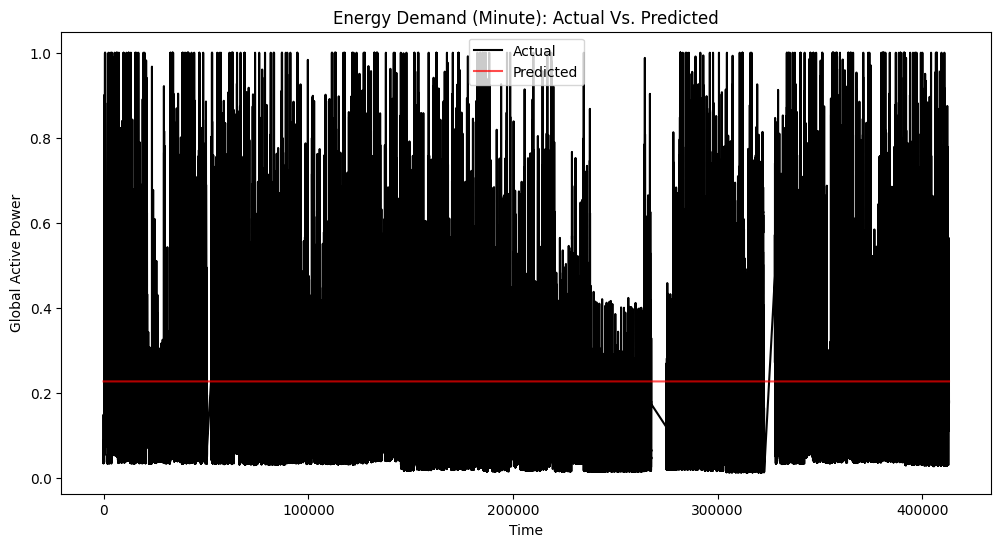

In [ ]:
plot_actual_vs_pred(y_min_test, y_pred_simple_min, "Minute")

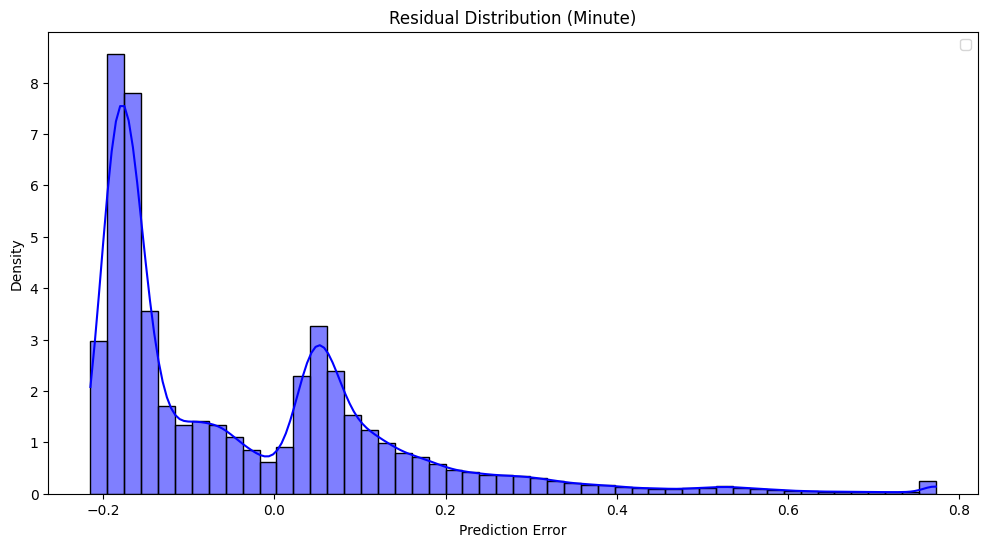

In [ ]:
plot_residuals(y_min_test, y_pred_simple_min, "Minute")

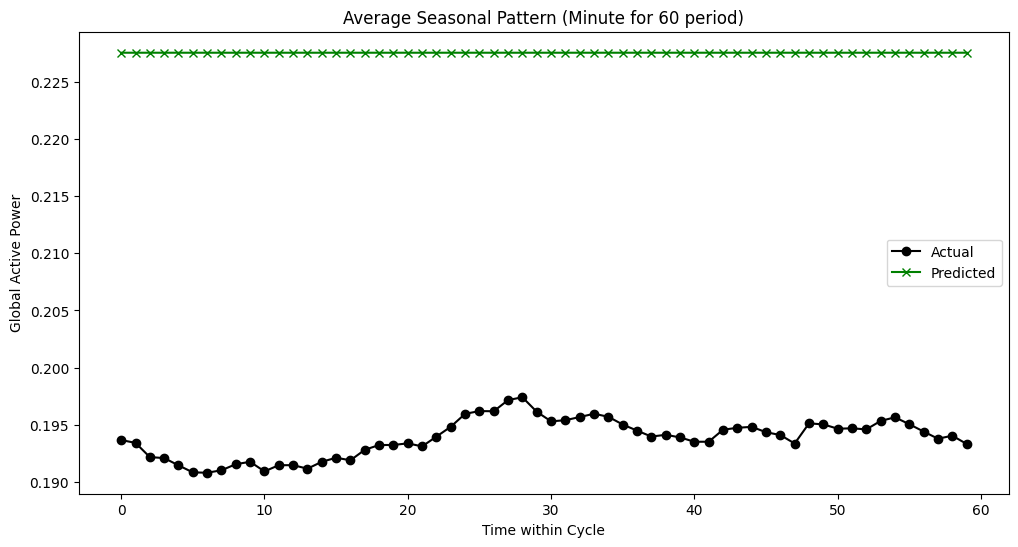

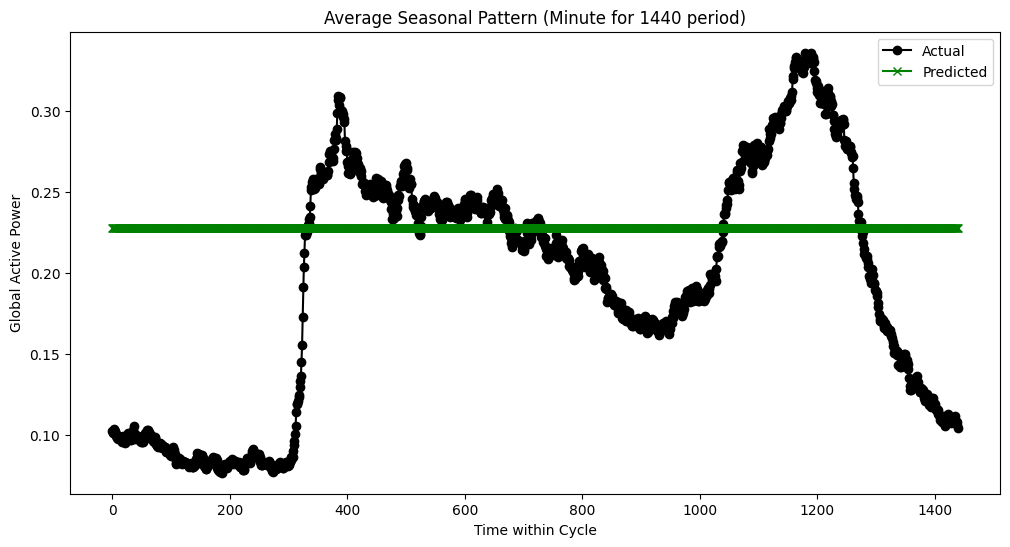

In [ ]:
plot_seasonal_patterns(y_min_test, y_pred_simple_min, 60, "Minute") # 1-hour ahead
plot_seasonal_patterns(y_min_test, y_pred_simple_min, 1440, "Minute") # 24-hour ahead

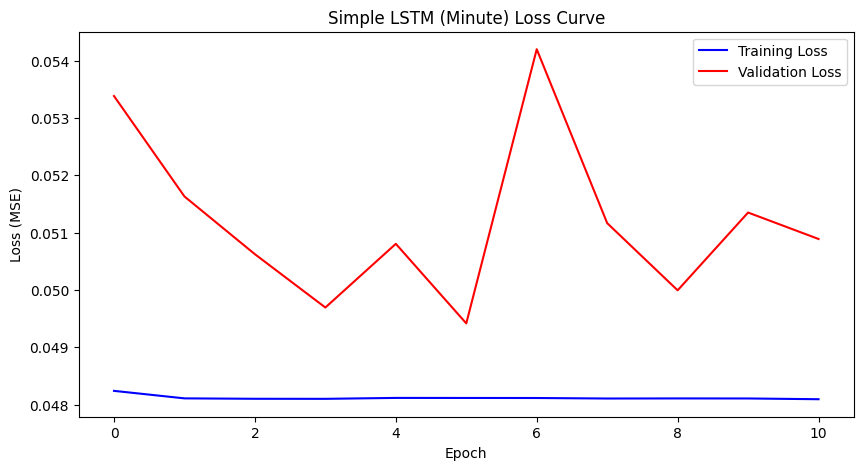

In [ ]:
plot_loss_curve(simple_min, "Simple LSTM", "Minute")

Hourly Data

In [ ]:
# Building Simple LSTM model
simple_lstm = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(X_hr_train.shape[1], X_hr_train.shape[2])),
    Dense(1)
])

simple_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
simple_hr = simple_lstm.fit(
    X_hr_train, y_hr_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_hr_val, y_hr_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0352 - val_loss: 0.0244
Epoch 2/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0248 - val_loss: 0.0199
Epoch 3/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0210 - val_loss: 0.0199
Epoch 4/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0203 - val_loss: 0.0253
Epoch 5/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 6/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0197 - val_loss: 0.0176
Epoch 7/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 8/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 9/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0183 - val_loss: 0.0173
Epoch 10/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 11/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 12/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_simple_hr = simple_lstm.predict(X_hr_test)
end_time = time.time()
simple_lstm_hr_time = end_time - start_time
results.append(evaluate_model(y_hr_test, y_pred_simple_hr, "Simple LSTM", "Hourly", simple_lstm_hr_time))

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Simple LSTM (Hourly) Evaluation: 
MSE  : 0.0118
MAE  : 0.0785
RMSE : 0.1088
R2   : 0.4540
Execution Time: 0.5349


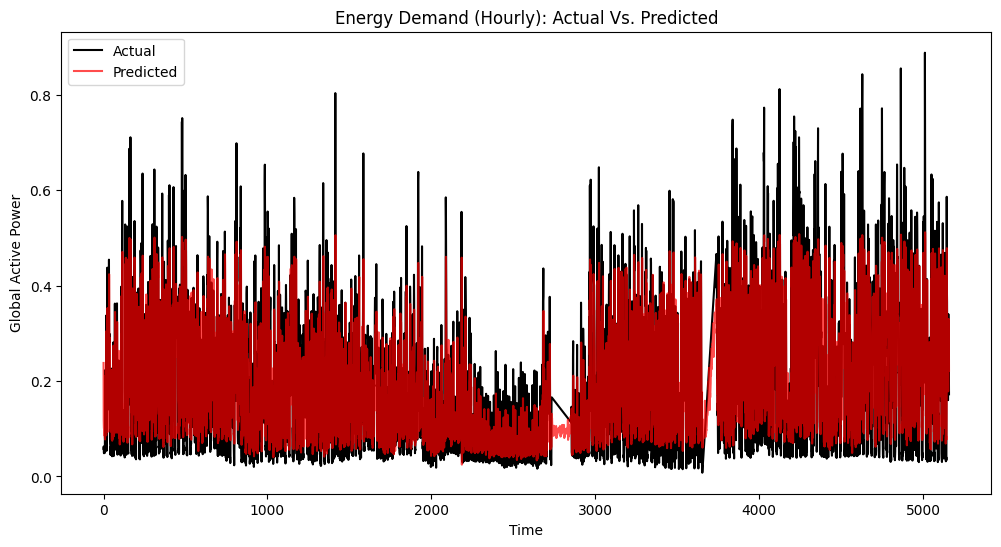

In [ ]:
plot_actual_vs_pred(y_hr_test, y_pred_simple_hr, "Hourly")

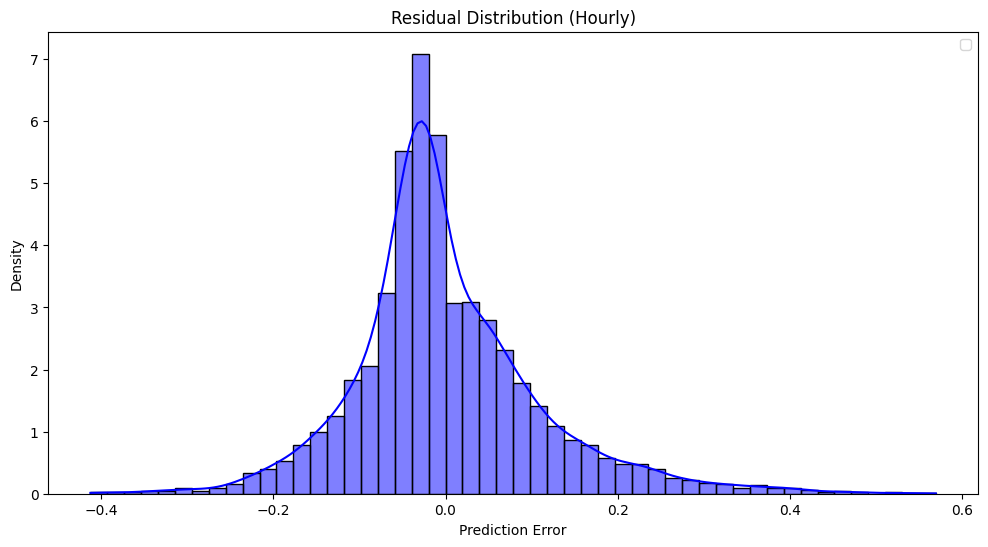

In [ ]:
plot_residuals(y_hr_test, y_pred_simple_hr, "Hourly")

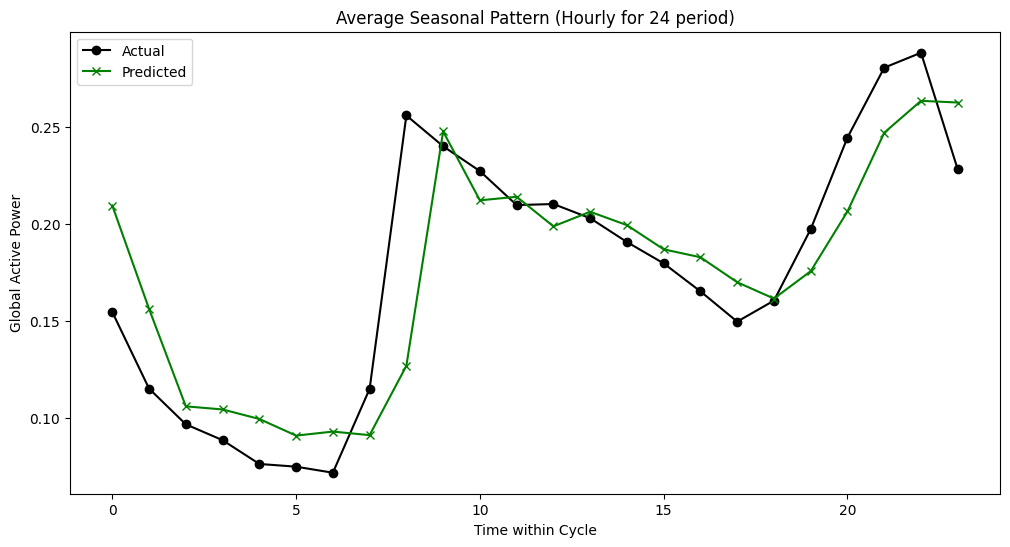

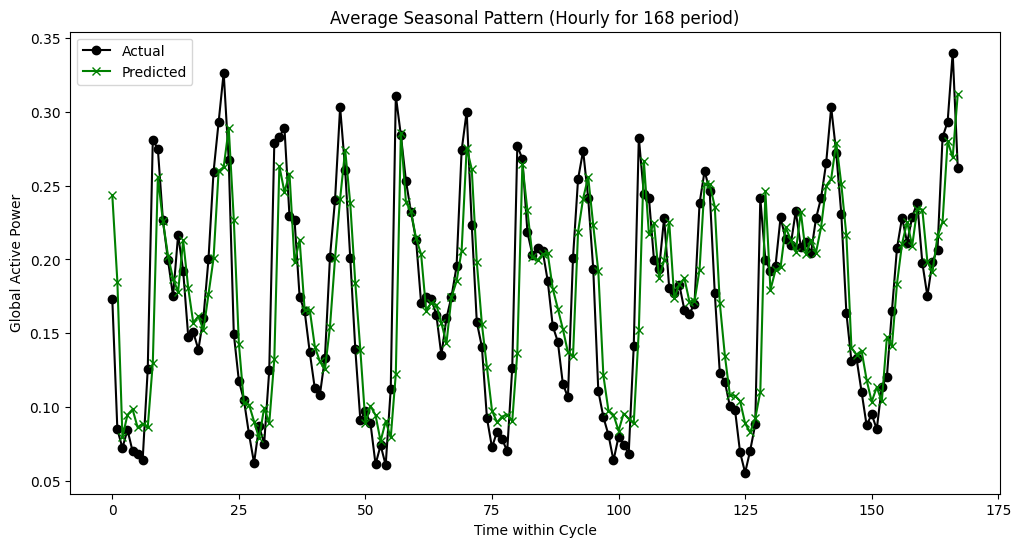

In [ ]:
plot_seasonal_patterns(y_hr_test, y_pred_simple_hr, 24, "Hourly") # 1-day ahead
plot_seasonal_patterns(y_hr_test, y_pred_simple_hr, 168, "Hourly") # 7-day ahead

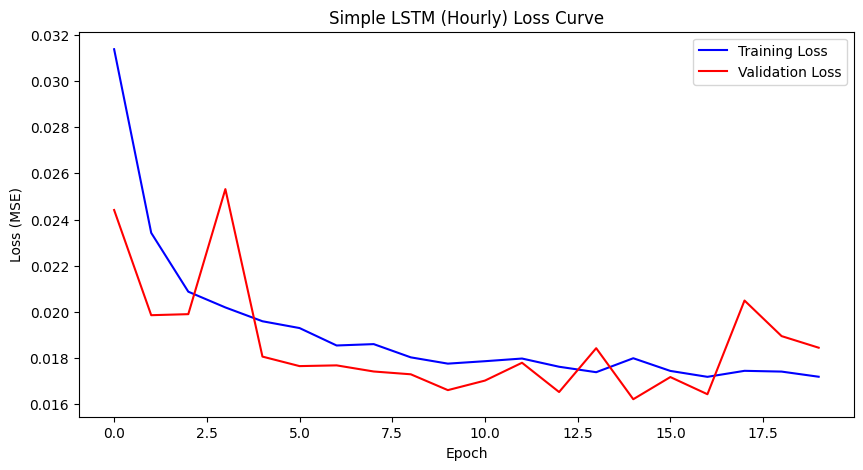

In [ ]:
plot_loss_curve(simple_hr, "Simple LSTM", "Hourly")

Daily Data

In [ ]:
# Building Simple LSTM model
simple_lstm = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])),
    Dense(1)
])

simple_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
simple_dy = simple_lstm.fit(
    X_dy_train, y_dy_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dy_val, y_dy_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0467 - val_loss: 0.0098
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0184 - val_loss: 0.0121
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - val_loss: 0.0113
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - val_loss: 0.0115
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179 - val_loss: 0.0110
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - val_loss: 0.0116


In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_simple_dy = simple_lstm.predict(X_dy_test)
end_time = time.time()
simple_lstm_dy_time = end_time - start_time
results.append(evaluate_model(y_dy_test, y_pred_simple_dy, "Simple LSTM", "Daily", simple_lstm_dy_time))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Simple LSTM (Daily) Evaluation: 
MSE  : 0.0177
MAE  : 0.1072
RMSE : 0.1332
R2   : -0.3456
Execution Time: 0.2162


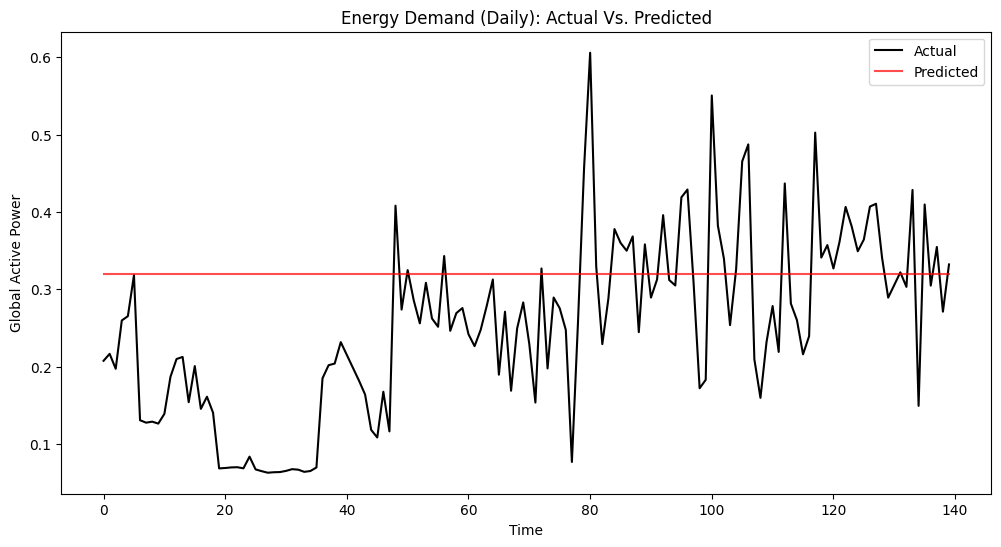

In [ ]:
plot_actual_vs_pred(y_dy_test, y_pred_simple_dy, "Daily")

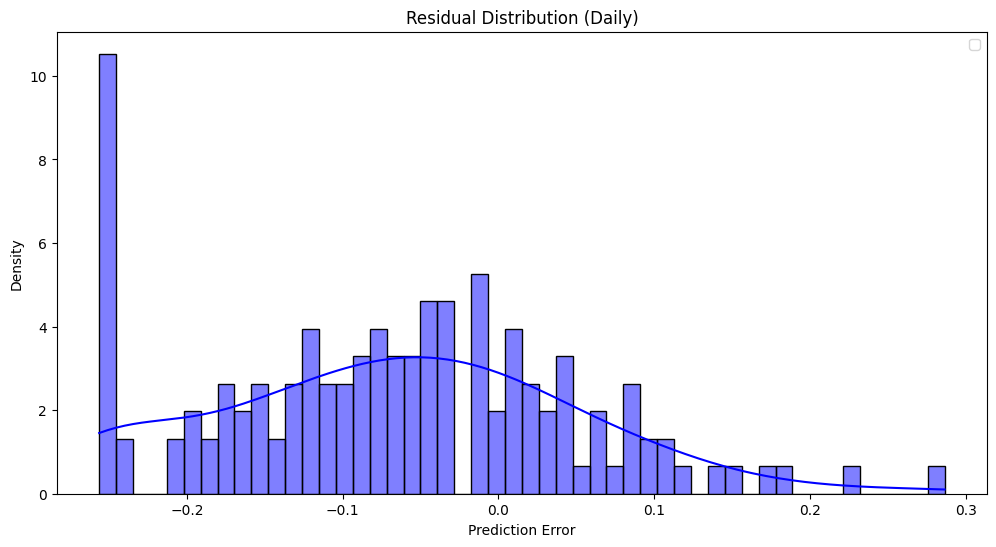

In [ ]:
plot_residuals(y_dy_test, y_pred_simple_dy, "Daily")

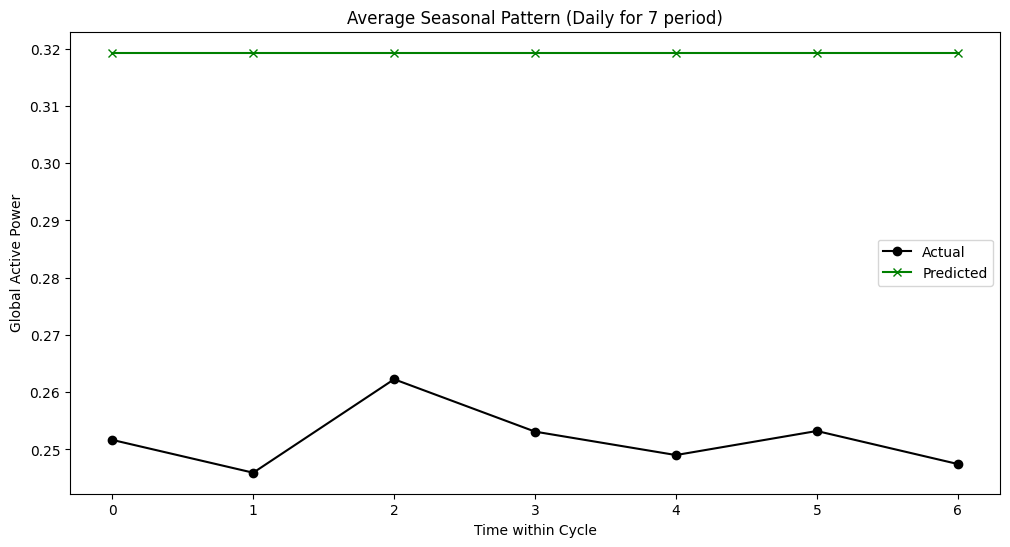

In [ ]:
plot_seasonal_patterns(y_dy_test, y_pred_simple_dy, 7, "Daily") # 1-week ahead

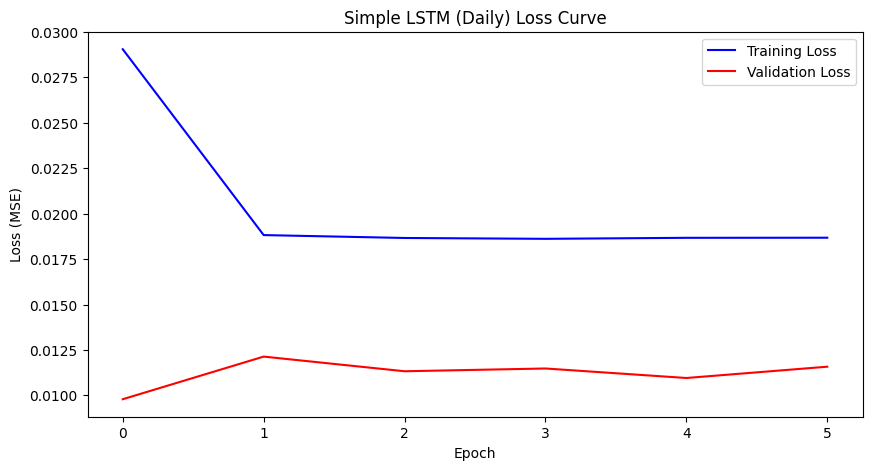

In [ ]:
plot_loss_curve(simple_dy, "Simple LSTM", "Daily")

### Stacked Sequential LSTM Model

Minute-level data

In [ ]:
# Building Stacked Sequential LSTM
stacked_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', input_shape=(X_min_train.shape[1], X_min_train.shape[2])),
    LSTM(units=32, activation='tanh'),  # Second LSTM layer
    Dense(1)  # Output for regression
])

stacked_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the stacked model
stacked_min = stacked_lstm.fit(
    X_min_train, y_min_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_min_val, y_min_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 334s 7ms/step - loss: 0.0483 - val_loss: 0.0519
Epoch 2/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 333s 7ms/step - loss: 0.0478 - val_loss: 0.0521
Epoch 3/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 326s 7ms/step - loss: 0.0479 - val_loss: 0.0510
Epoch 4/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0477 - val_loss: 0.0507
Epoch 5/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 327s 7ms/step - loss: 0.0478 - val_loss: 0.0511
Epoch 6/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 330s 7ms/step - loss: 0.0479 - val_loss: 0.0501
Epoch 7/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0477 - val_loss: 0.0516
Epoch 8/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0478 - val_loss: 0.0508
Epoch 9/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 10/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0480 - val_loss: 0.0510
Epoch 11/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 325s 7ms/step - loss: 0.0478 - val

In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_stacked_min = stacked_lstm.predict(X_min_test)
end_time = time.time()
stacked_lstm_min_time = end_time - start_time
results.append(evaluate_model(y_min_test, y_pred_stacked_min, "Stacked LSTM", "Minute", stacked_lstm_min_time))

12907/12907 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
Stacked LSTM (Minute) Evaluation: 
MSE  : 0.0332
MAE  : 0.1488
RMSE : 0.1821
R2   : -0.0168
Execution Time: 42.3667


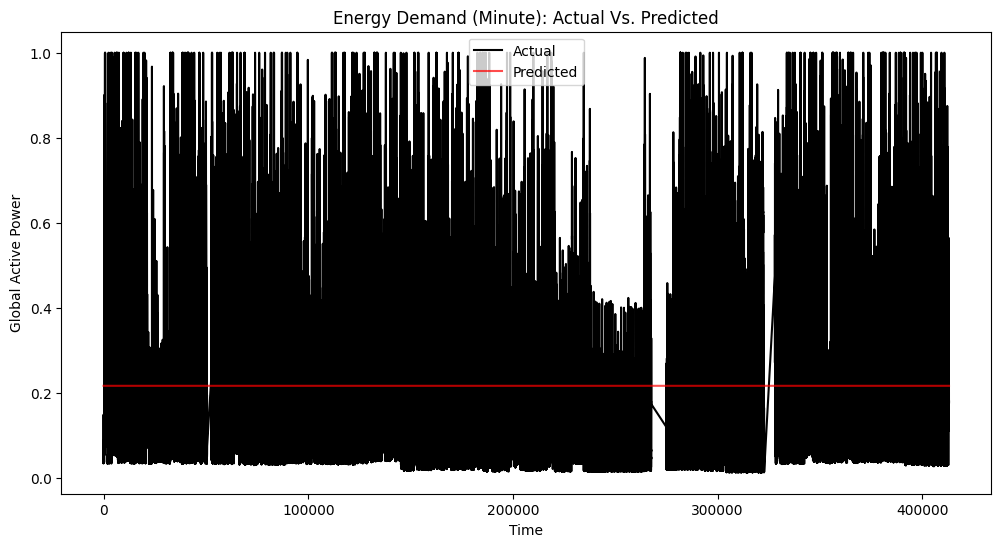

In [ ]:
plot_actual_vs_pred(y_min_test, y_pred_stacked_min, "Minute")

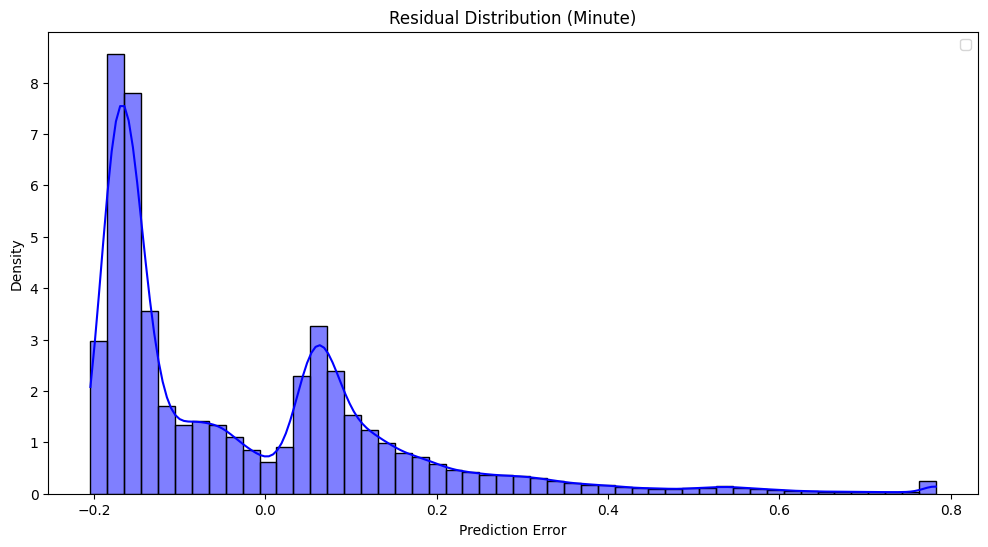

In [ ]:
plot_residuals(y_min_test, y_pred_stacked_min, "Minute")

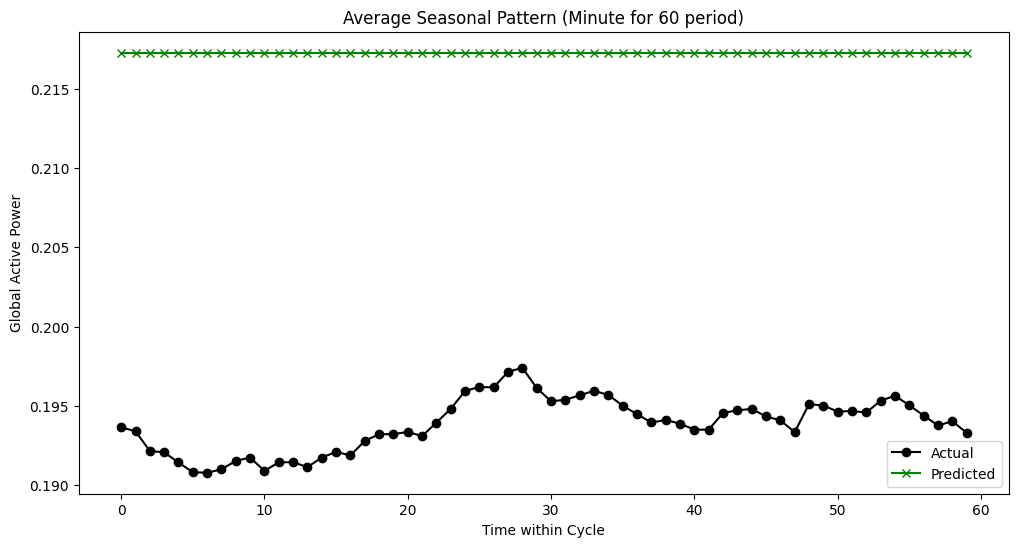

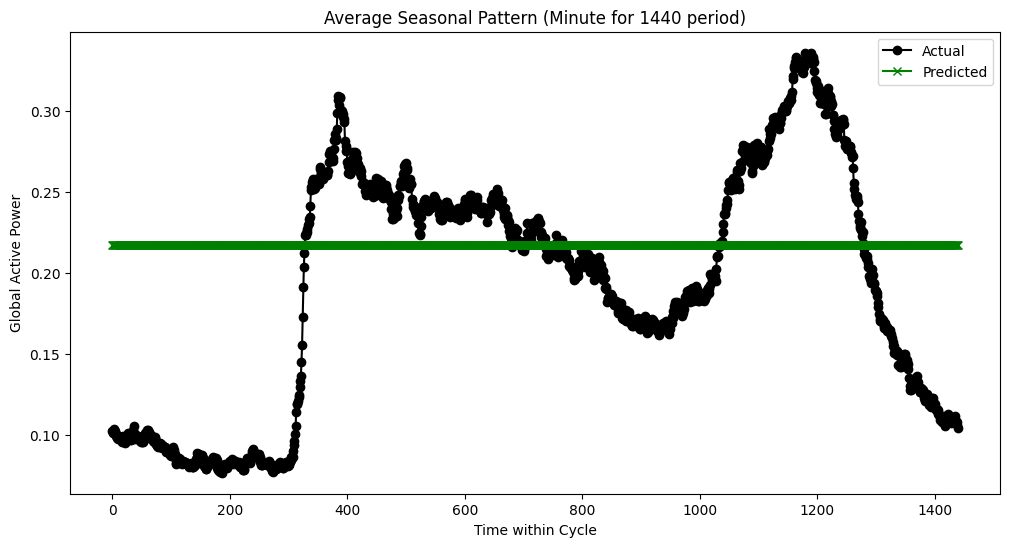

In [ ]:
plot_seasonal_patterns(y_min_test, y_pred_stacked_min, 60, "Minute") # 1-hour ahead
plot_seasonal_patterns(y_min_test, y_pred_stacked_min, 1440, "Minute") # 24-hour ahead

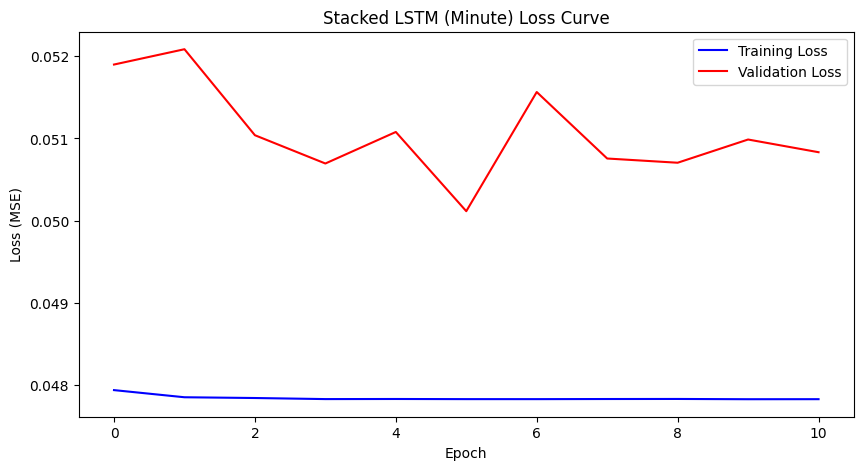

In [ ]:
plot_loss_curve(stacked_min, "Stacked LSTM", "Minute")

Hourly Data

In [ ]:
# Building Stacked Sequential LSTM
stacked_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', input_shape=(X_hr_train.shape[1], X_hr_train.shape[2])),
    LSTM(units=32, activation='tanh'),  # Second LSTM layer
    Dense(1)  # Output for regression
])

stacked_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the stacked model
stacked_hr = stacked_lstm.fit(
    X_hr_train, y_hr_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_hr_val, y_hr_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0594 - val_loss: 0.0341
Epoch 2/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0366 - val_loss: 0.0335
Epoch 3/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0366 - val_loss: 0.0343
Epoch 4/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0370 - val_loss: 0.0338
Epoch 5/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0362 - val_loss: 0.0356
Epoch 6/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0361 - val_loss: 0.0360
Epoch 7/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0366 - val_loss: 0.0361


In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_stacked_hr = stacked_lstm.predict(X_hr_test)
end_time = time.time()
stacked_lstm_hr_time = end_time - start_time
results.append(evaluate_model(y_hr_test, y_pred_stacked_hr, "Stacked LSTM", "Hourly", stacked_lstm_hr_time))

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Stacked LSTM (Hourly) Evaluation: 
MSE  : 0.0245
MAE  : 0.1363
RMSE : 0.1565
R2   : -0.1293
Execution Time: 0.6954


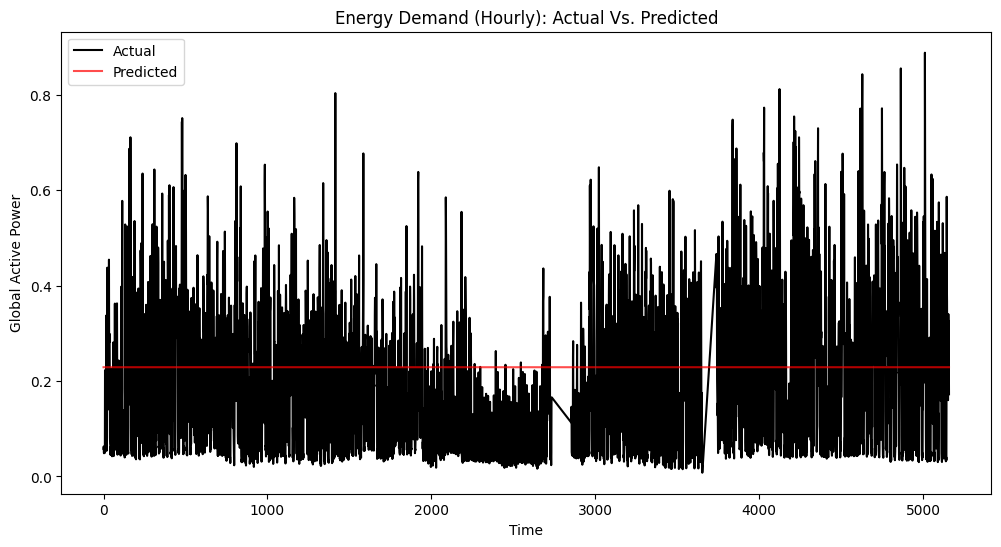

In [ ]:
plot_actual_vs_pred(y_hr_test, y_pred_stacked_hr, "Hourly")

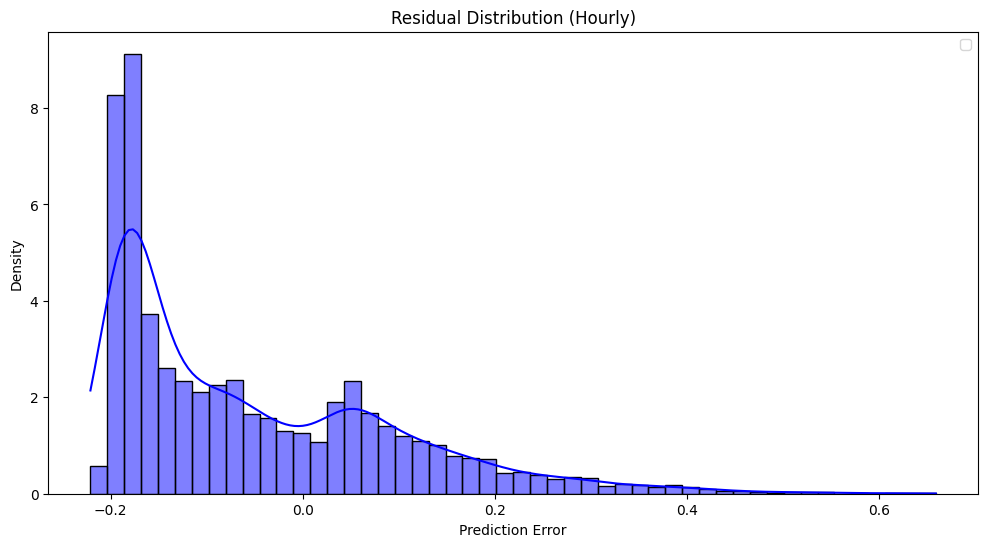

In [ ]:
plot_residuals(y_hr_test, y_pred_stacked_hr, "Hourly")

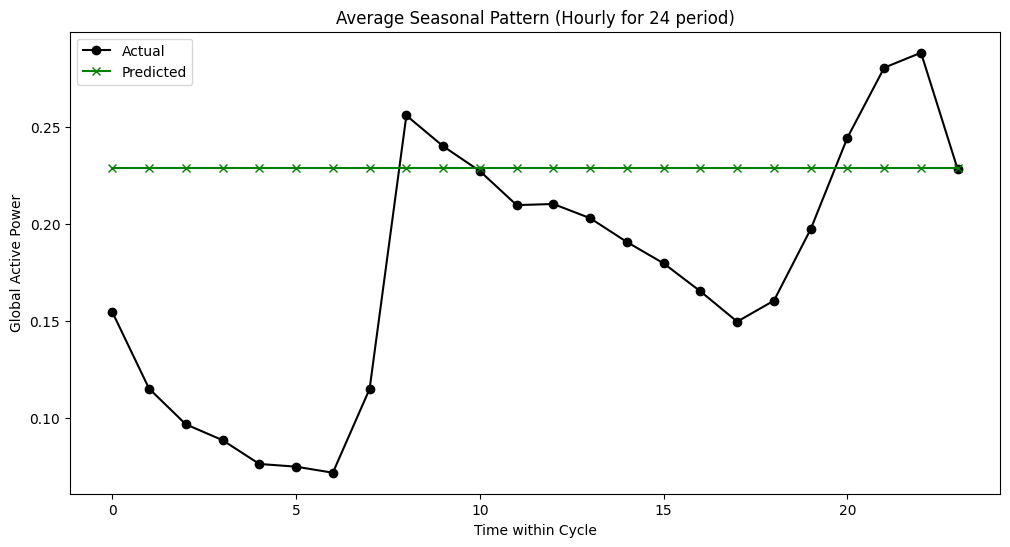

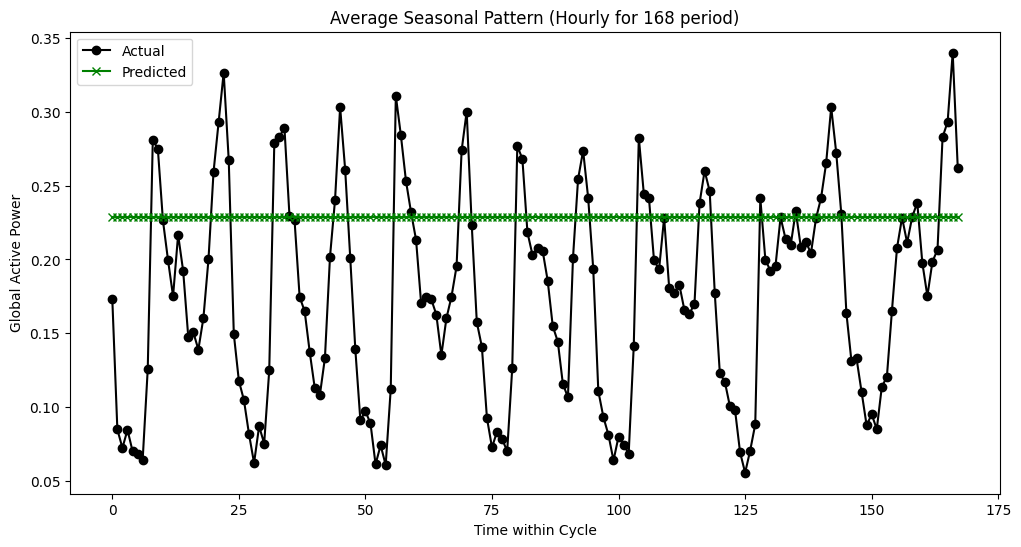

In [ ]:
plot_seasonal_patterns(y_hr_test, y_pred_stacked_hr, 24, "Hourly") # 1-day ahead
plot_seasonal_patterns(y_hr_test, y_pred_stacked_hr, 168, "Hourly") # 7-day ahead

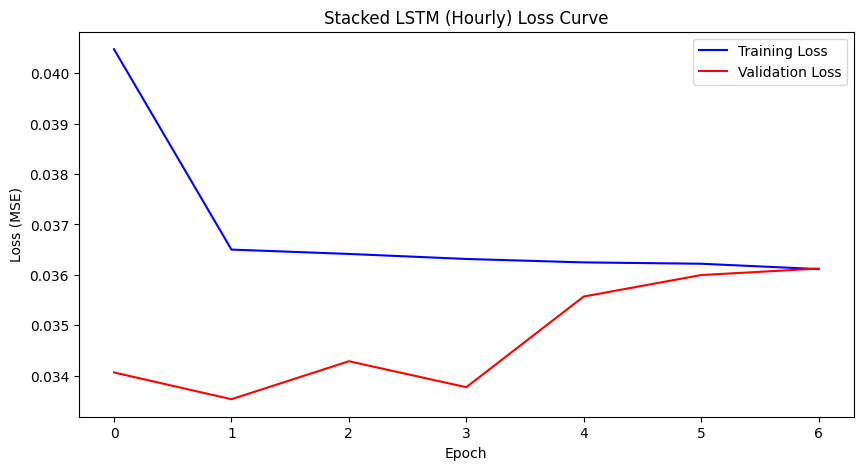

In [ ]:
plot_loss_curve(stacked_hr, "Stacked LSTM", "Hourly")

Daily Data

In [ ]:
# Building Stacked Sequential LSTM
stacked_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])),
    LSTM(units=32, activation='tanh'),  # Second LSTM layer
    Dense(1)  # Output for regression
])

stacked_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the stacked model
stacked_dy = stacked_lstm.fit(
    X_dy_train, y_dy_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dy_val, y_dy_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1271 - val_loss: 0.0161
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - val_loss: 0.0115
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - val_loss: 0.0102
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194 - val_loss: 0.0113
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - val_loss: 0.0106
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0146
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0189 - val_loss: 0.0122
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - val_loss: 0.0124


In [ ]:
# Evaluate on test set
start_time = time.time()
y_pred_stacked_dy = stacked_lstm.predict(X_dy_test)
end_time = time.time()
stacked_lstm_dy_time = end_time - start_time
results.append(evaluate_model(y_dy_test, y_pred_stacked_dy, "Stacked LSTM", "Daily", stacked_lstm_dy_time))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Stacked LSTM (Daily) Evaluation: 
MSE  : 0.0165
MAE  : 0.1030
RMSE : 0.1284
R2   : -0.2503
Execution Time: 0.3243


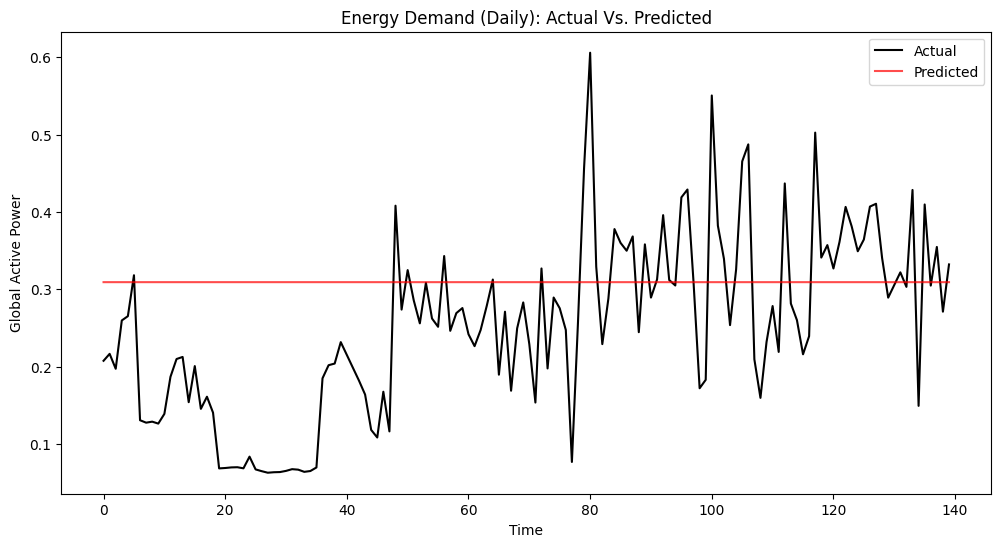

In [ ]:
plot_actual_vs_pred(y_dy_test, y_pred_stacked_dy, "Daily")

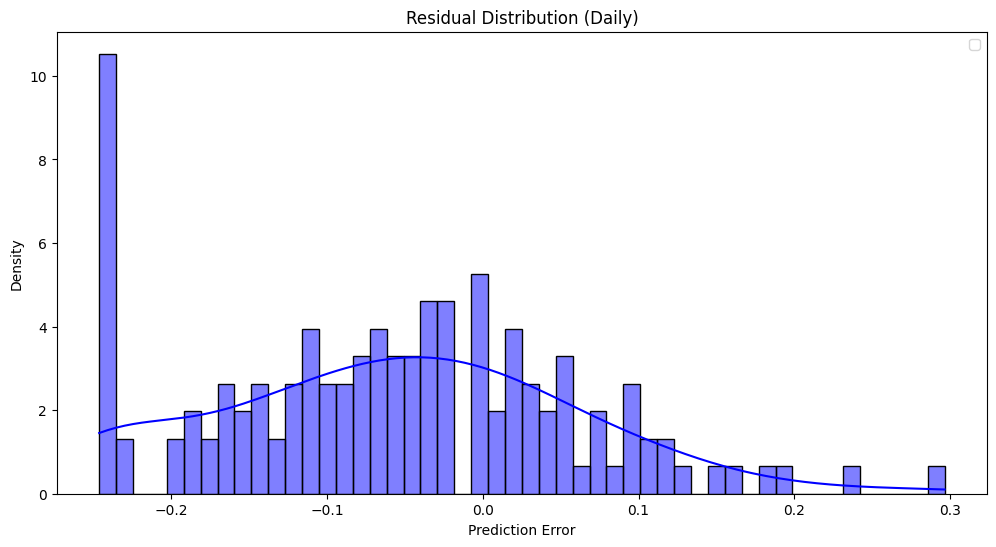

In [ ]:
plot_residuals(y_dy_test, y_pred_stacked_dy, "Daily")

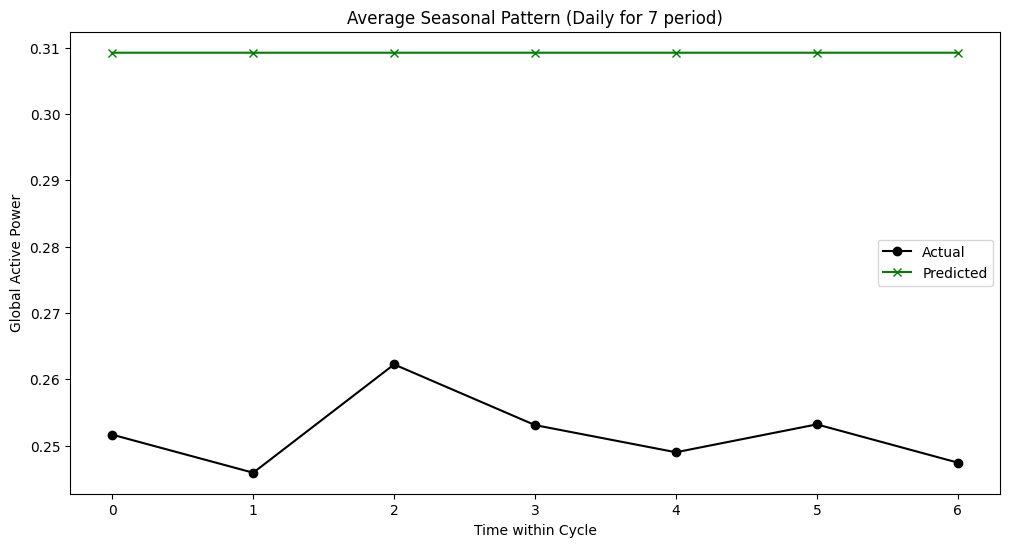

In [ ]:
plot_seasonal_patterns(y_dy_test, y_pred_stacked_dy, 7, "Daily") # 1-week ahead

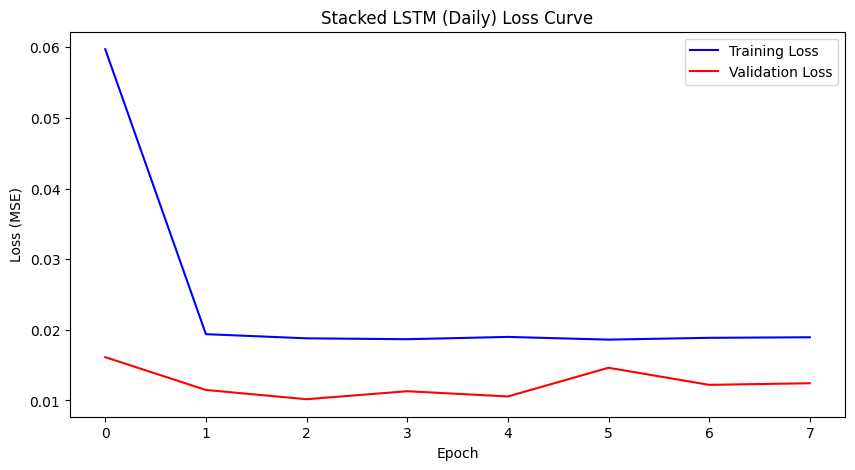

In [ ]:
plot_loss_curve(stacked_dy, "Stacked LSTM", "Daily")

### Bidirectional LSTM

Minute-level Data

In [ ]:
# Building Bidirectional LSTM

bidirectional_lstm = Sequential([
    Bidirectional(LSTM(units=64, activation='tanh'), input_shape=(X_min_train.shape[1], X_min_train.shape[2])),
    Dense(1)  # Output for regression
])

bidirectional_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the bidirectional model
bidirectional_min = bidirectional_lstm.fit(
    X_min_train, y_min_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_min_val, y_min_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 328s 7ms/step - loss: 0.0486 - val_loss: 0.0522
Epoch 2/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 322s 7ms/step - loss: 0.0485 - val_loss: 0.0509
Epoch 3/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 322s 7ms/step - loss: 0.0484 - val_loss: 0.0496
Epoch 4/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 326s 7ms/step - loss: 0.0484 - val_loss: 0.0500
Epoch 5/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 324s 7ms/step - loss: 0.0484 - val_loss: 0.0549
Epoch 6/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 323s 7ms/step - loss: 0.0485 - val_loss: 0.0509
Epoch 7/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 323s 7ms/step - loss: 0.0485 - val_loss: 0.0500
Epoch 8/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 323s 7ms/step - loss: 0.0486 - val_loss: 0.0494
Epoch 9/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 324s 7ms/step - loss: 0.0484 - val_loss: 0.0534
Epoch 10/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 323s 7ms/step - loss: 0.0484 - val_loss: 0.0486
Epoch 11/50
45175/45175 ━━━━━━━━━━━━━━━━━━━━ 323s 7ms/step - loss: 0.0484 - val

In [ ]:
start_time = time.time()
y_pred_bi_min = bidirectional_lstm.predict(X_min_test)
end_time = time.time()
bi_lstm_min_time = end_time - start_time
results.append(evaluate_model(y_min_test, y_pred_bi_min, "Bidirectional LSTM", "Minute", bi_lstm_min_time))

12907/12907 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step
Bidirectional LSTM (Minute) Evaluation: 
MSE  : 0.0362
MAE  : 0.1578
RMSE : 0.1904
R2   : -0.1113
Execution Time: 43.7972


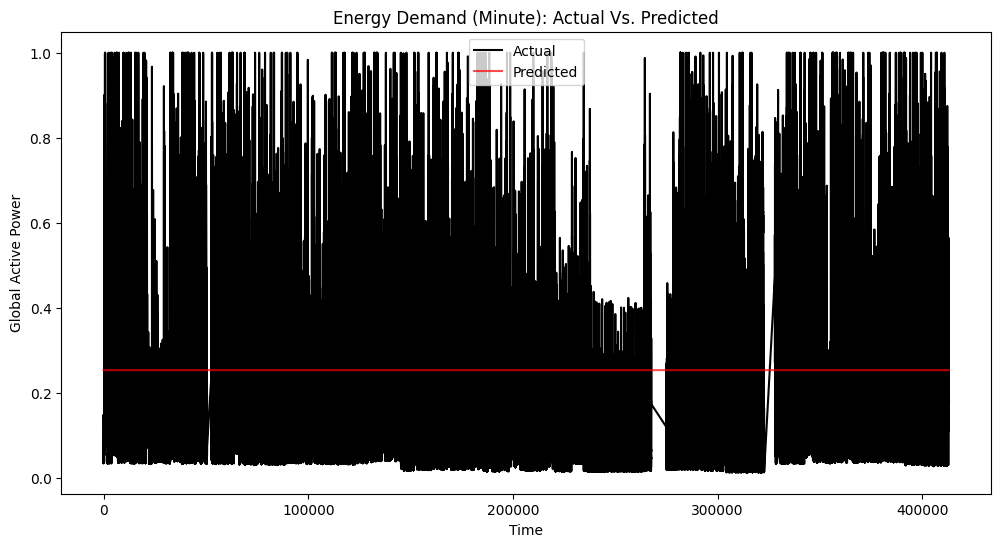

In [ ]:
plot_actual_vs_pred(y_min_test, y_pred_bi_min, "Minute")

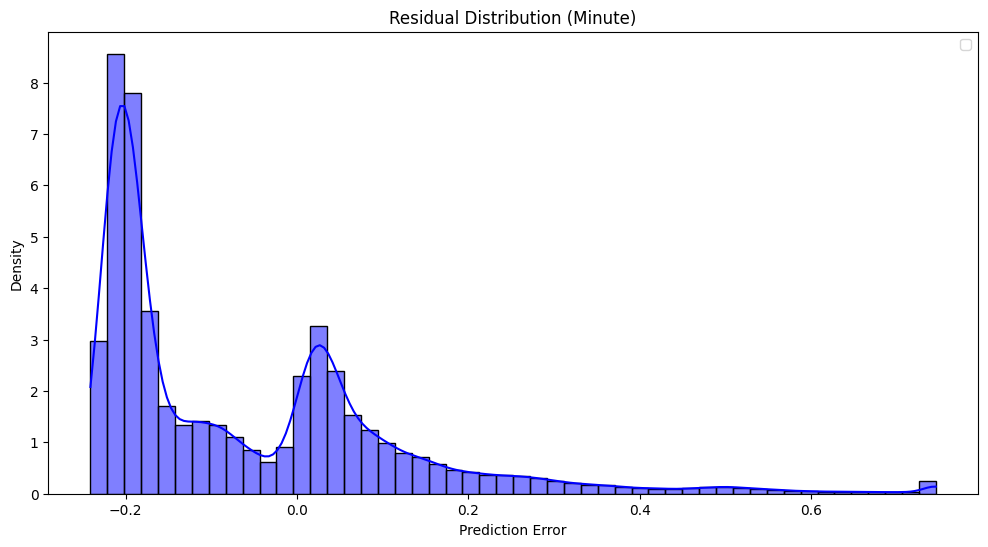

In [ ]:
plot_residuals(y_min_test, y_pred_bi_min, "Minute")

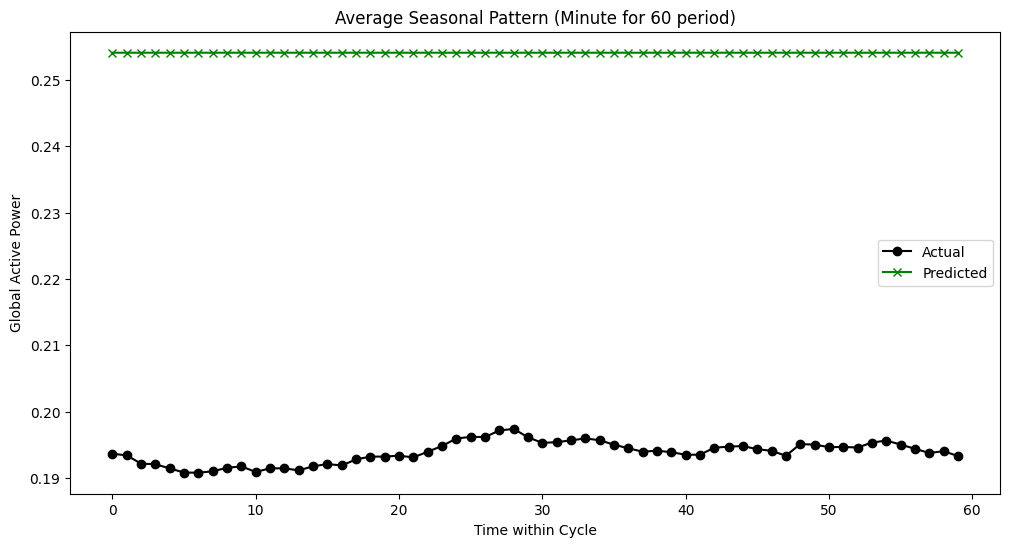

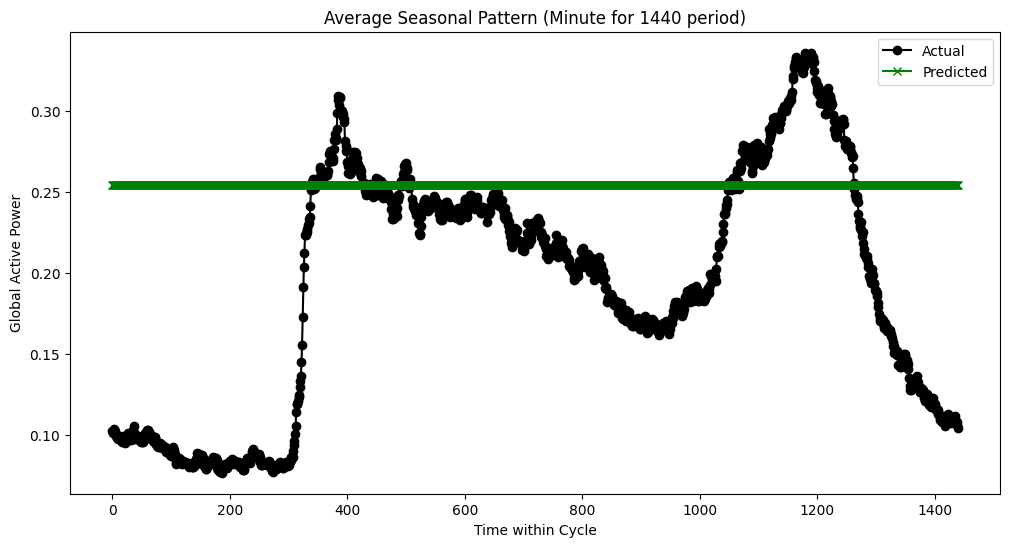

In [ ]:
plot_seasonal_patterns(y_min_test, y_pred_bi_min, 60, "Minute") # 1-hour ahead
plot_seasonal_patterns(y_min_test, y_pred_bi_min, 1440, "Minute") # 24-hour ahead

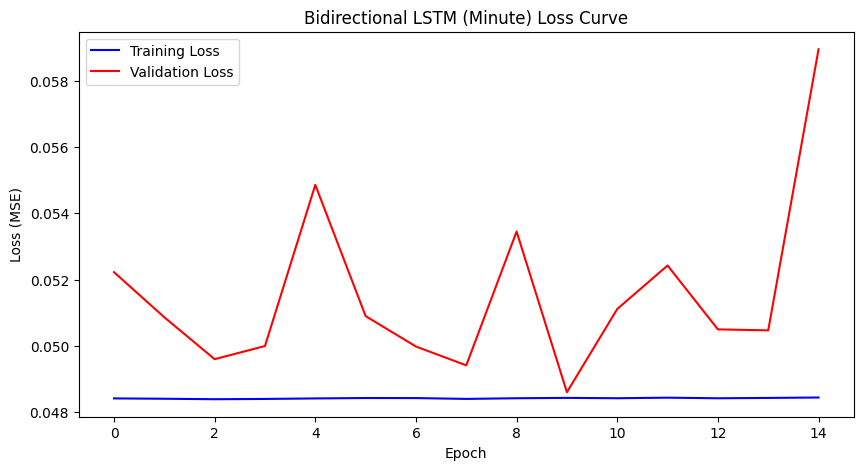

In [ ]:
plot_loss_curve(bidirectional_min, "Bidirectional LSTM", "Minute")

Hourly Data

In [ ]:
# Building Bidirectional LSTM

bidirectional_lstm = Sequential([
    Bidirectional(LSTM(units=64, activation='tanh'), input_shape=(X_hr_train.shape[1], X_hr_train.shape[2])),
    Dense(1)  # Output for regression
])

bidirectional_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the bidirectional model
bidirectional_hr = bidirectional_lstm.fit(
    X_hr_train, y_hr_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_hr_val, y_hr_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0368 - val_loss: 0.0354
Epoch 2/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0365 - val_loss: 0.0354
Epoch 3/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0370 - val_loss: 0.0358
Epoch 4/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0367 - val_loss: 0.0434
Epoch 5/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0370 - val_loss: 0.0362
Epoch 6/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0363 - val_loss: 0.0357


In [ ]:
# Evaluating on unseen test data
start_time = time.time()
y_pred_bi_hr = bidirectional_lstm.predict(X_hr_test)
end_time = time.time()
bi_lstm_hr_time = end_time - start_time
results.append(evaluate_model(y_hr_test, y_pred_bi_hr, "Bidirectional LSTM", "Hourly", bi_lstm_hr_time))

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Bidirectional LSTM (Hourly) Evaluation: 
MSE  : 0.0220
MAE  : 0.1253
RMSE : 0.1484
R2   : -0.0148
Execution Time: 0.7355


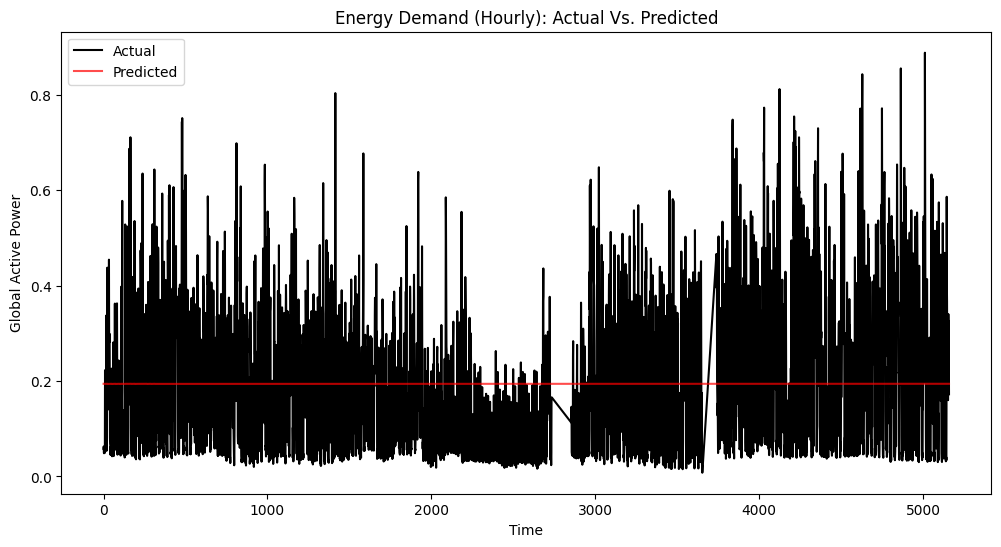

In [ ]:
plot_actual_vs_pred(y_hr_test, y_pred_bi_hr, "Hourly")

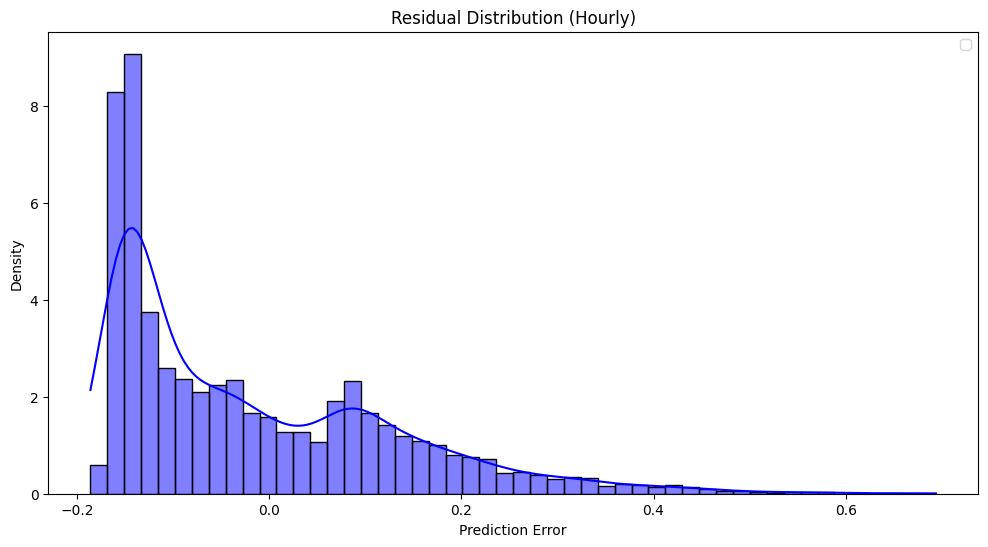

In [ ]:
plot_residuals(y_hr_test, y_pred_bi_hr, "Hourly")

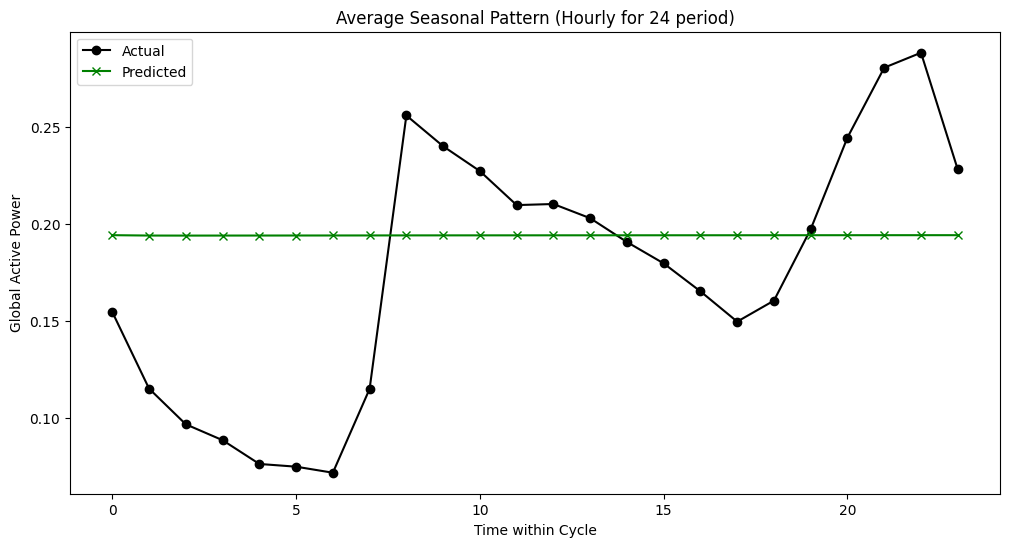

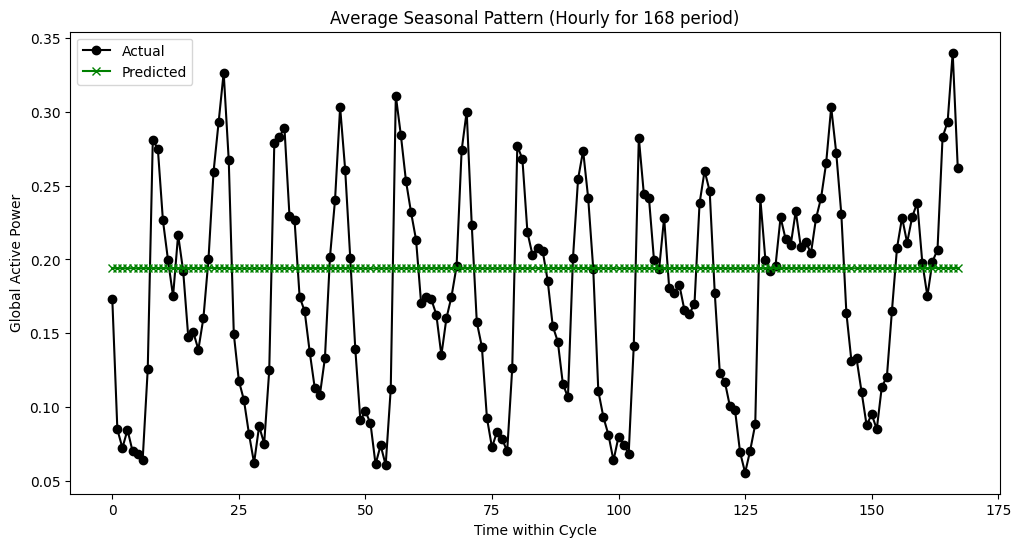

In [ ]:
plot_seasonal_patterns(y_hr_test, y_pred_bi_hr, 24, "Hourly") # 1-day ahead
plot_seasonal_patterns(y_hr_test, y_pred_bi_hr, 168, "Hourly") # 7-day ahead

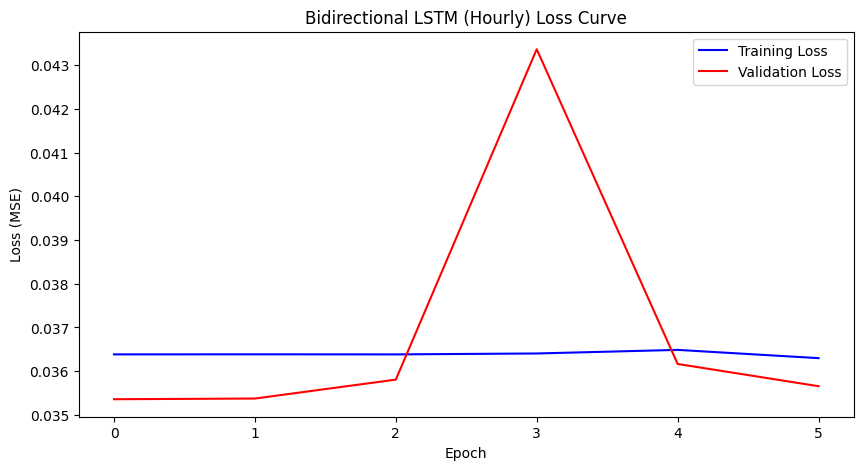

In [ ]:
plot_loss_curve(bidirectional_hr, "Bidirectional LSTM", "Hourly")

Daily Data

In [ ]:
# Building Bidirectional LSTM

bidirectional_lstm = Sequential([
    Bidirectional(LSTM(units=64, activation='tanh'), input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])),
    Dense(1)  # Output for regression
])

bidirectional_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the bidirectional model
bidirectional_dy = bidirectional_lstm.fit(
    X_dy_train, y_dy_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dy_val, y_dy_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0421 - val_loss: 0.0104
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - val_loss: 0.0103
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - val_loss: 0.0116
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - val_loss: 0.0107
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0205 - val_loss: 0.0105
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - val_loss: 0.0103
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0176 - val_loss: 0.0115


In [ ]:
# evaluating on test set

start_time = time.time()
y_pred_bi_dy = bidirectional_lstm.predict(X_dy_test)
end_time = time.time()
bi_lstm_dy_time = end_time - start_time
results.append(evaluate_model(y_dy_test, y_pred_bi_dy, "Bidirectional LSTM", "Daily", bi_lstm_dy_time))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Bidirectional LSTM (Daily) Evaluation: 
MSE  : 0.0163
MAE  : 0.1025
RMSE : 0.1277
R2   : -0.2370
Execution Time: 0.3336


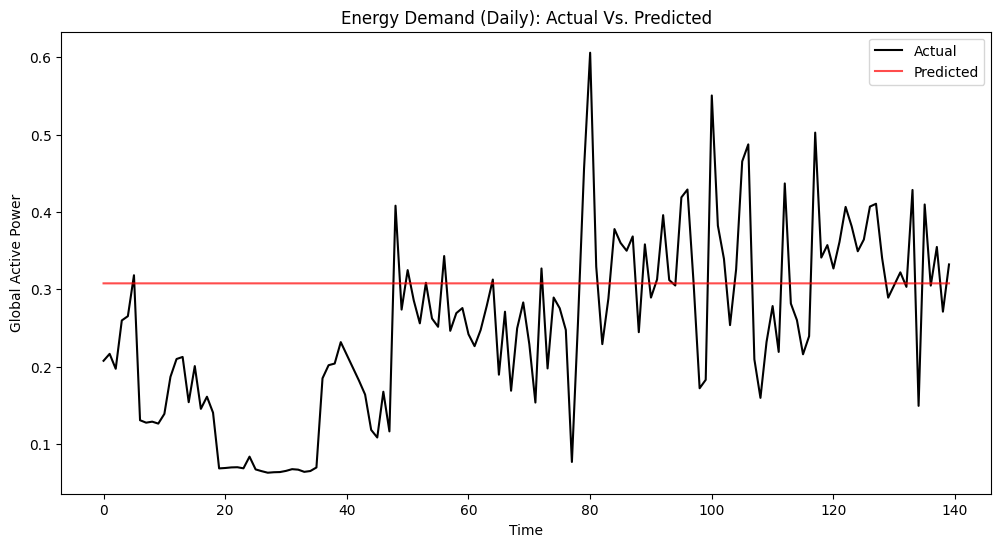

In [ ]:
plot_actual_vs_pred(y_dy_test, y_pred_bi_dy, "Daily")

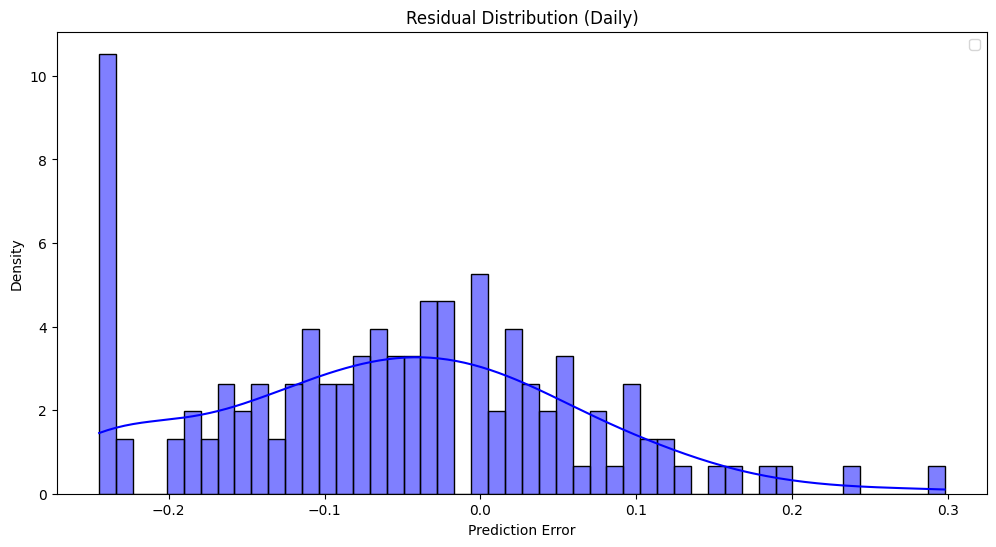

In [ ]:
plot_residuals(y_dy_test, y_pred_bi_dy, "Daily")

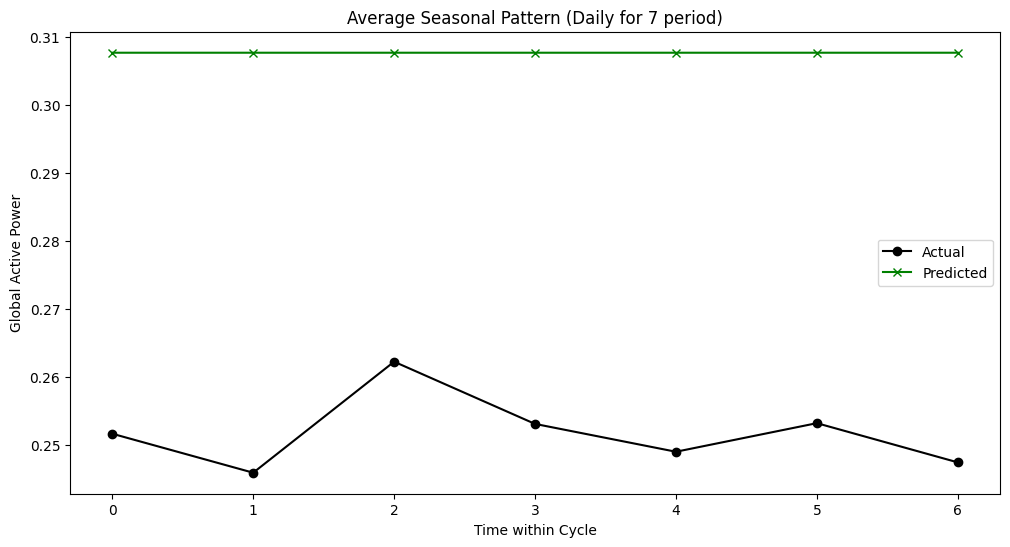

In [ ]:
plot_seasonal_patterns(y_dy_test, y_pred_bi_dy, 7, "Daily") # 1-week ahead

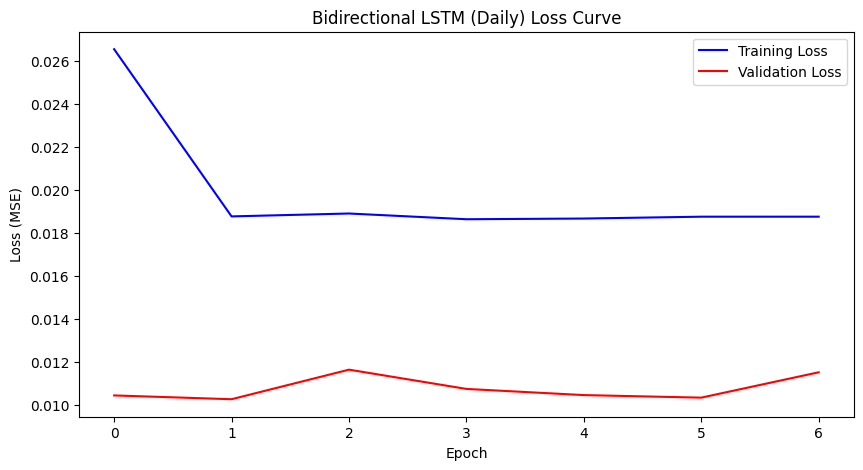

In [ ]:
plot_loss_curve(bidirectional_dy, "Bidirectional LSTM", "Daily")

### Comparison of Results

In [ ]:
# Comparison of the results

results_df = pd.DataFrame(results)
print("Comparison of the results of the model performance: \n")
print(results_df)

Comparison of the results of the model performance: 

                Model Frequency       MSE       MAE      RMSE  R2 Score  \
0         Simple LSTM    Minute  0.033752  0.151100  0.183717 -0.034884   
1         Simple LSTM    Hourly  0.011843  0.078529  0.108825  0.454042   
2         Simple LSTM     Daily  0.017732  0.107216  0.133160 -0.345582   
3        Stacked LSTM    Minute  0.033163  0.148782  0.182106 -0.016811   
4        Stacked LSTM    Hourly  0.024497  0.136279  0.156514 -0.129307   
5        Stacked LSTM     Daily  0.016476  0.103030  0.128360 -0.250327   
6  Bidirectional LSTM    Minute  0.036244  0.157777  0.190378 -0.111281   
7  Bidirectional LSTM    Hourly  0.022013  0.125288  0.148369 -0.014823   
8  Bidirectional LSTM     Daily  0.016301  0.102463  0.127675 -0.237013   

   Execution Time  
0       34.935815  
1        0.534925  
2        0.216157  
3       42.366671  
4        0.695369  
5        0.324303  
6       43.797187  
7        0.735483  
8        0.3335

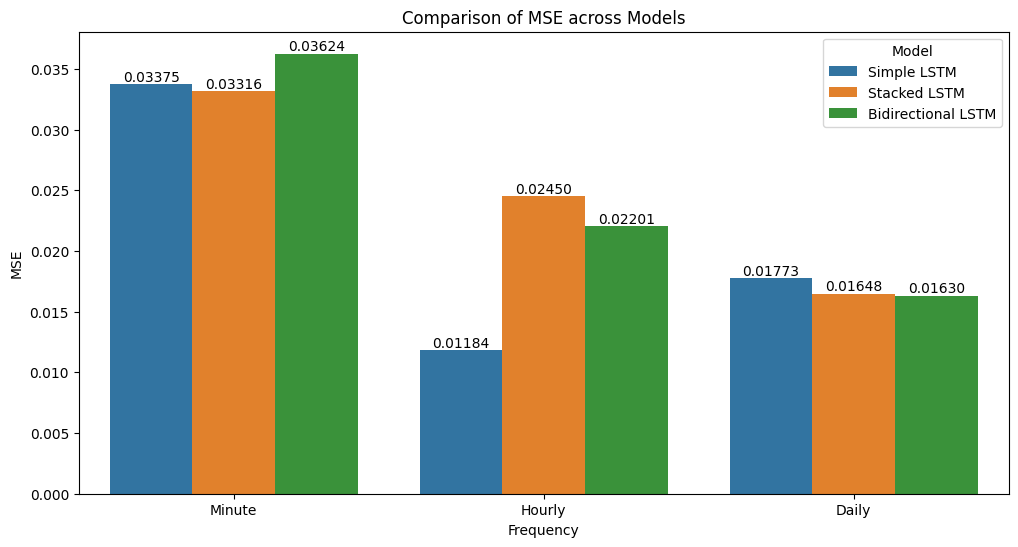

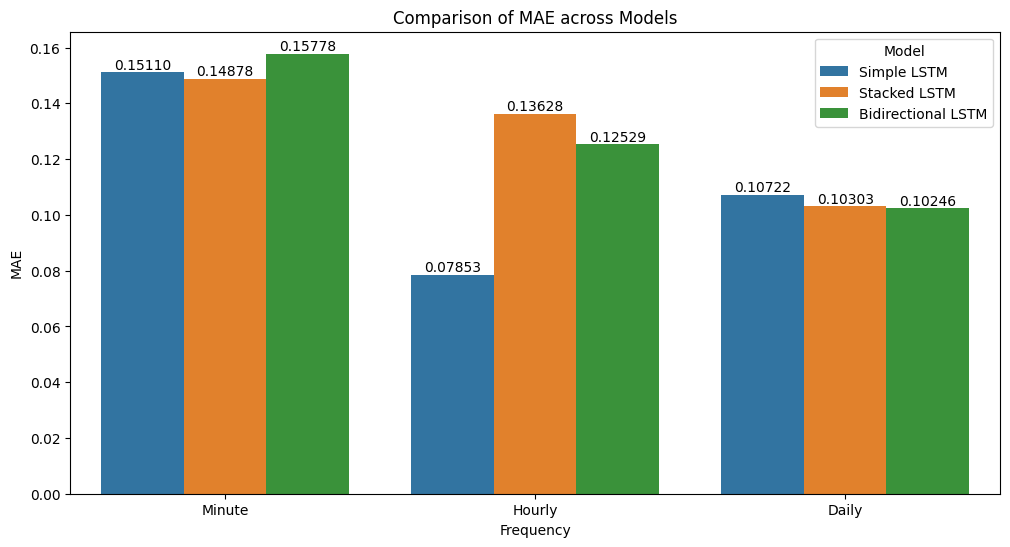

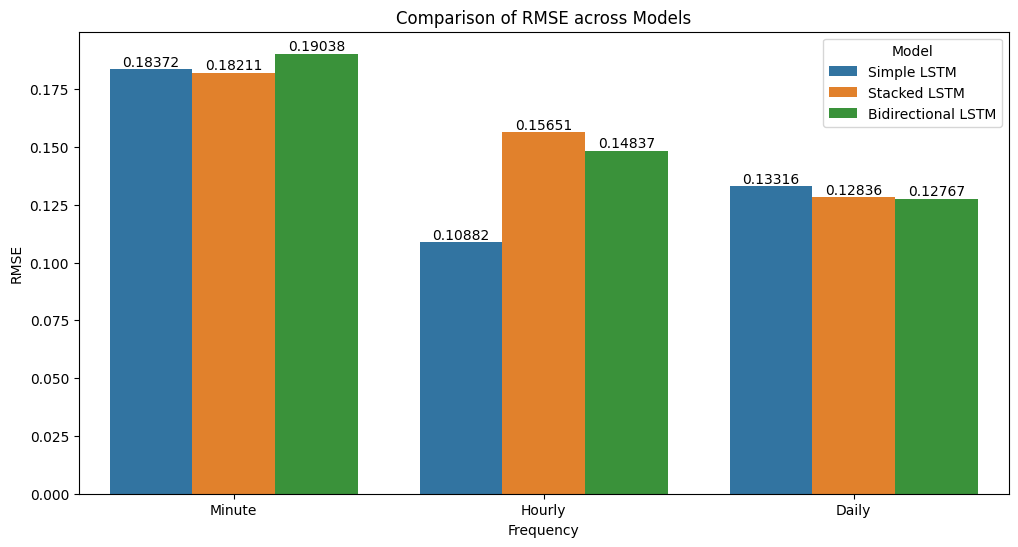

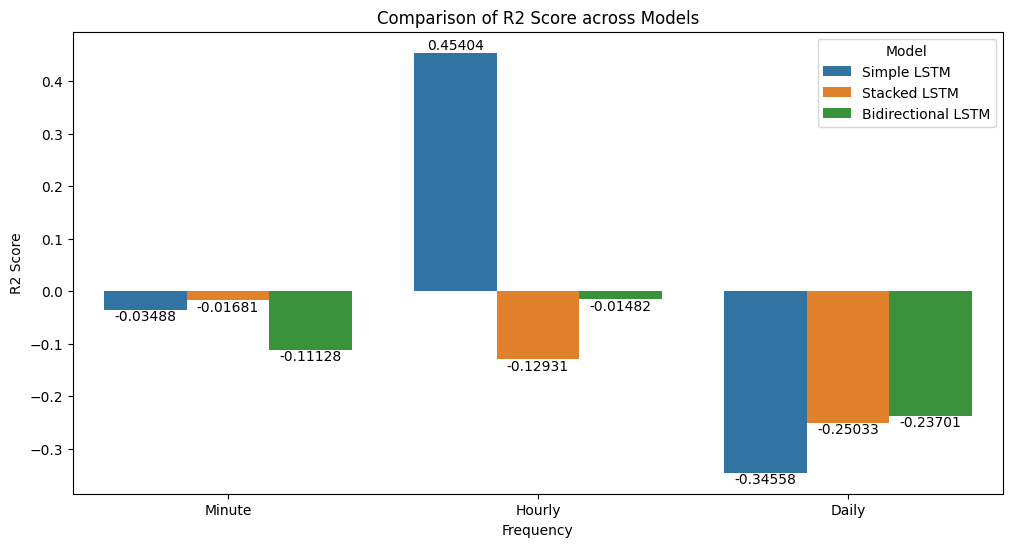

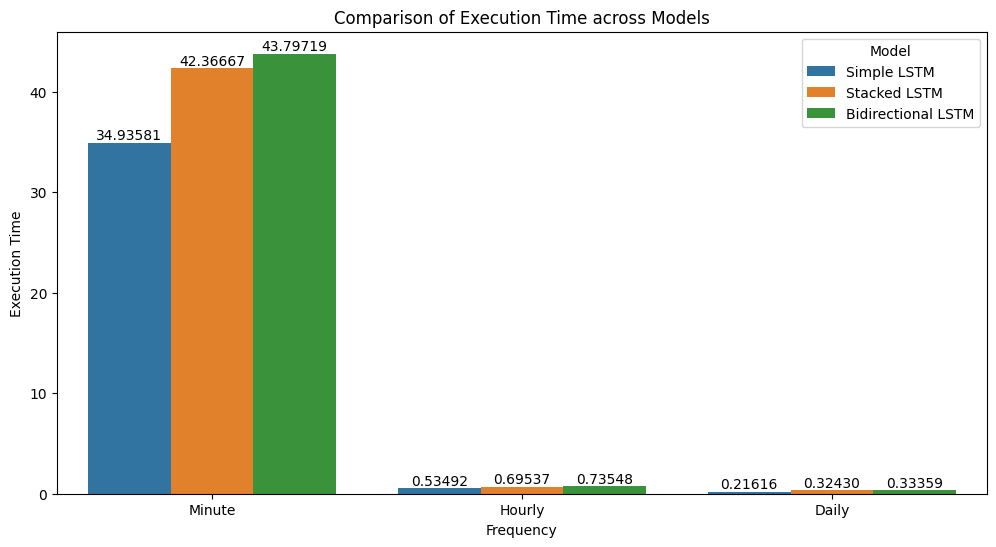

In [ ]:
# Bar Plots of metrics across models

metrics_col = ["MSE", "MAE", "RMSE", "R2 Score", "Execution Time"]
for col in metrics_col:
  plt.figure(figsize=(12, 6))
  ax = sns.barplot(data=results_df, x="Frequency", y=col, hue="Model")
  plt.title(f"Comparison of {col} across Models")
  plt.xlabel("Frequency")
  plt.ylabel(col)

  # Add values on top of the bars
  for container in ax.containers:
      ax.bar_label(container, fmt='%.5f')

  plt.show()

## Hyperparameter Tuning

Hyperparameter tuning for the LSTM models was coded using the help of Gemini AI.

The skeleton of the hyperparameter tuning function and model building function was obtained from Gemini and then structured and personalised to fit the models coded above.

In [ ]:
results_tuned = []

In [ ]:
%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import time

First, running tuning on daily data as it is smaller and can be run easily.

This is to narrow down the parameter grid.

In [ ]:
def build_model(hp):

  # proposing a number of LSTM units
  hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)

  # Dropout rates
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)

  # Learning rates
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = Sequential()

  # Simple or Stacked LSTM -- model building
  if hp.Boolean('stacked'):
    model.add(LSTM(units=hp_units_1,
                   return_sequences=True,
                   activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dropout_1))
    model.add(LSTM(units=hp_units_2, activation='tanh'))
    model.add(Dropout(hp_dropout_2))
  else:
    model.add(LSTM(units=hp_units_1,
                   activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dropout_1))

  model.add(Dense(1))

  # compile the model with the learning rate proposed above.
  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=optimizer, loss='mse')

  return model

In [ ]:
# Create tuner instance
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning'
)

In [ ]:
# Run the search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Trial 20 Complete [00h 00m 20s]
val_loss: 0.009856142569333315

Best val_loss So Far: 0.00962011981755495
Total elapsed time: 00h 06m 50s


In [ ]:
# Print the best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'units_1': 128, 'units_2': 64, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.01, 'stacked': False}


In [ ]:
# build the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,465 (306.50 KB)

 Trainable params: 78,465 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

### Hyperparameter Tuning tailored for the different data frequencies

In [ ]:
def build_model1(hp):

  # Narrowed range of parameters
  hp_units_1 = hp.Int('units_1', min_value=64, max_value=256, step=64)
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-5])
  hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)

  model_type = hp.Choice('model_type', values=['simple', 'stacked', 'bidirectional'])

  model = Sequential()
  if model_type == 'simple': # simple
    model.add(LSTM(units=hp_units_1, activation='tanh', input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])))
    model.add(Dropout(hp_dropout))
  elif model_type == 'stacked': # stacked
    model.add(LSTM(units=hp_units_1, return_sequences=True, activation='tanh', input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units_2, activation='tanh'))
    model.add(Dropout(hp_dropout))
  else: # bidirectional
    model.add(Bidirectional(LSTM(units=hp_units_1, activation='tanh'), input_shape=(X_dy_train.shape[1], X_dy_train.shape[2])))
    model.add(Dropout(hp_dropout))

  model.add(Dense(1))

  optimizer = Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=optimizer, loss='mse')

  return model

Minute-level Data

In [ ]:
# Instantiate tuner tailored for minute data
# fewer trials and one execution per trial.
# This is because minute data is too large.
tuner_minute = kt.RandomSearch(
    build_model1,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning_minute'
)

In [ ]:
# Reduced patience to stop early -- for minute-level data hyperparammeter tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# running the search
tuner_minute.search(
    X_min_train, y_min_train,
    epochs=20, # reduced epochs for faster iteration
    batch_size=64, # larger batch size to speed up training
    validation_data=(X_min_val, y_min_val),
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 00m 01s]

Best val_loss So Far: 0.002619619481265545
Total elapsed time: 01h 35m 30s


In [ ]:
best_hps_min = tuner_minute.get_best_hyperparameters(num_trials=1)[0]
best_model_min = tuner_minute.get_best_models(num_models=1)[0]

In [ ]:
print("Best Hyperparameters for Minute-level Data:")
print(best_hps_min.values)
print("Best Model Summary:")
best_model_min.summary()

Best Hyperparameters for Minute-level Data:
{'units_1': 256, 'units_2': 96, 'learning_rate': 5e-05, 'dropout': 0.1, 'model_type': 'simple'}
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,001 (1.10 MB)

 Trainable params: 288,001 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()
y_pred_min = best_model_min.predict(X_min_test)
end_time = time.time()
min_time = end_time - start_time

12907/12907 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


In [ ]:
results_tuned.append(evaluate_model(y_min_test, y_pred_min, "Best Tuned LSTM", "Minute", min_time))

Best Tuned LSTM (Minute) Evaluation: 
MSE  : 0.0019
MAE  : 0.0176
RMSE : 0.0439
R2   : 0.9410
Execution Time: 36.8010


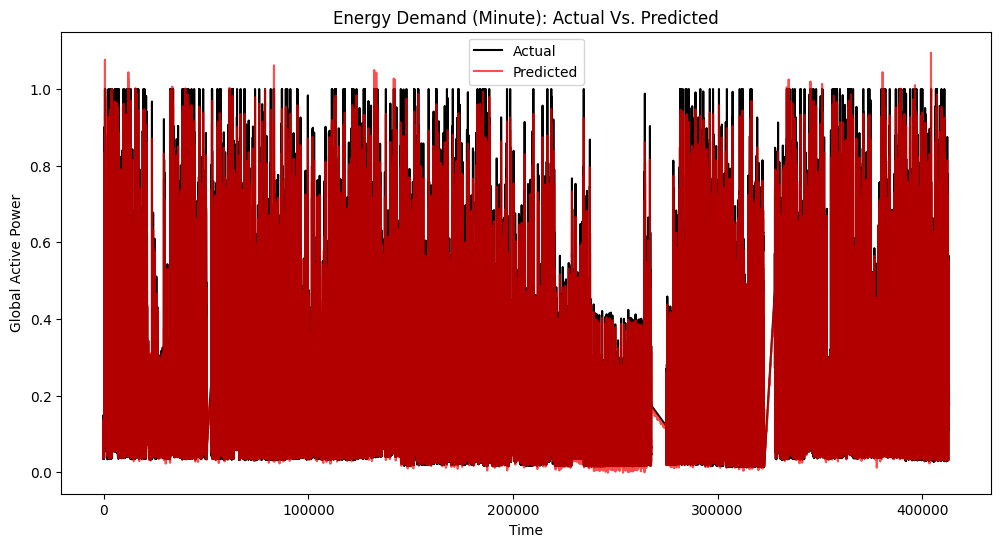

In [ ]:
plot_actual_vs_pred(y_min_test, y_pred_min, "Minute")

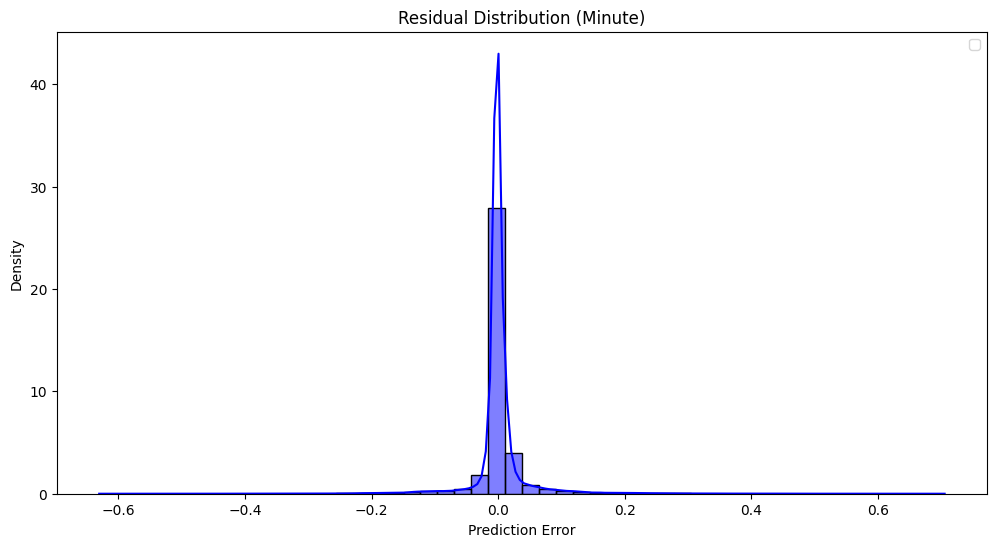

In [ ]:
plot_residuals(y_min_test, y_pred_min, "Minute")

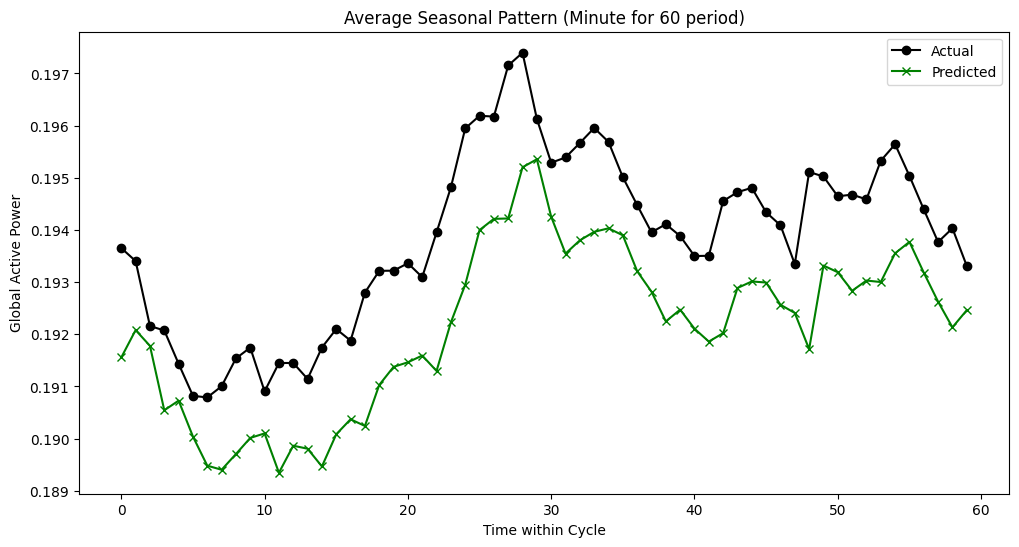

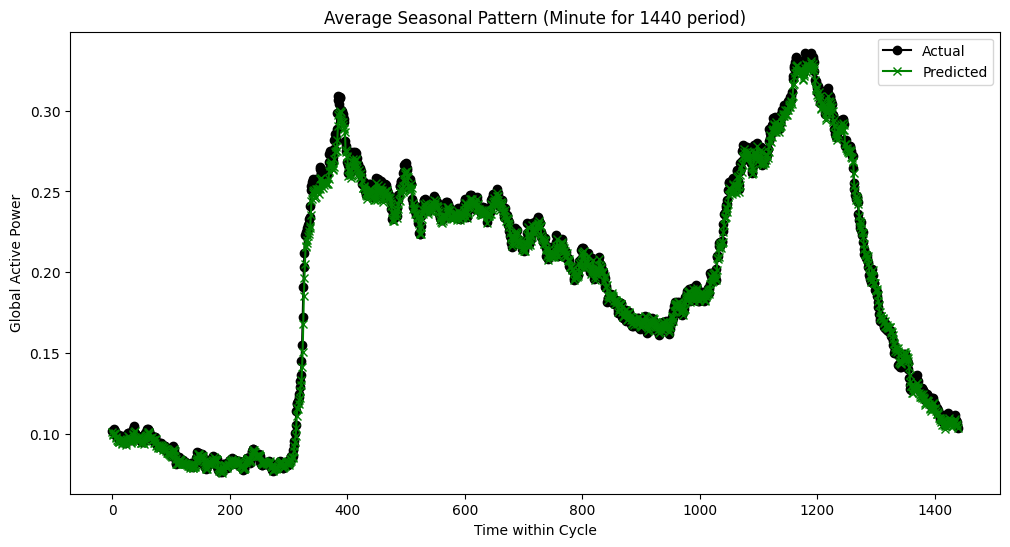

In [ ]:
plot_seasonal_patterns(y_min_test, y_pred_min, 60, "Minute") # 1-hour ahead
plot_seasonal_patterns(y_min_test, y_pred_min, 1440, "Minute") # 24-hour ahead

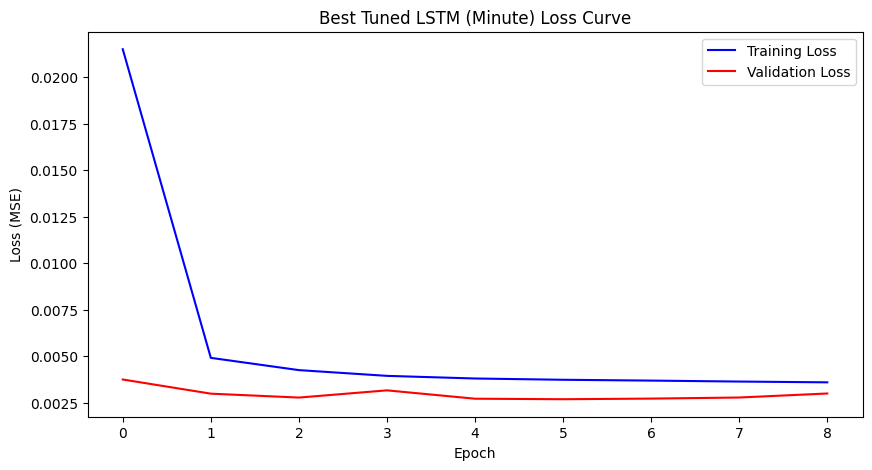

In [ ]:
best_model_min1 = tuner_minute.hypermodel.build(best_hps_min)

history_min = best_model_min1.fit(
    X_min_train, y_min_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_min_val, y_min_val),
    callbacks=[early_stopping],
    verbose=0
)

plot_loss_curve(history_min, "Best Tuned LSTM", "Minute")

Hourly Data

In [ ]:
# Instantiate tuner for hourly data
tuner_hourly = kt.RandomSearch(
    build_model1,
    objective='val_loss',
    max_trials=15, # slightly more number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning_hourly'
)

Reloading Tuner from my_dir/lstm_tuning_hourly/tuner0.json


In [ ]:
# running the tuner
tuner_hourly.search(
    X_hr_train, y_hr_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_hr_val, y_hr_val),
    callbacks=[early_stop]
)

Trial 15 Complete [00h 01m 44s]
val_loss: 0.021062269806861877

Best val_loss So Far: 0.015598704107105732
Total elapsed time: 00h 21m 02s


In [ ]:
best_hps_hr = tuner_hourly.get_best_hyperparameters(num_trials=1)[0]
best_model_hr = tuner_hourly.get_best_models(num_models=1)[0]

In [ ]:
print("Best Hyperparameters for Hourly-level Data:")
print(best_hps_hr.values)
print("Best Model Summary:")
best_model_hr.summary()

Best Hyperparameters for Hourly-level Data:
{'units_1': 128, 'units_2': 128, 'learning_rate': 0.0001, 'dropout': 0.4, 'model_type': 'stacked'}
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,049 (820.50 KB)

 Trainable params: 210,049 (820.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()
y_pred_hr = best_model_hr.predict(X_hr_test)
end_time = time.time()
hr_time = end_time - start_time

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
results_tuned.append(evaluate_model(y_hr_test, y_pred_hr, "Best Tuned LSTM", "Hourly", hr_time))

Best Tuned LSTM (Hourly) Evaluation: 
MSE  : 0.0120
MAE  : 0.0811
RMSE : 0.1096
R2   : 0.4467
Execution Time: 0.7945


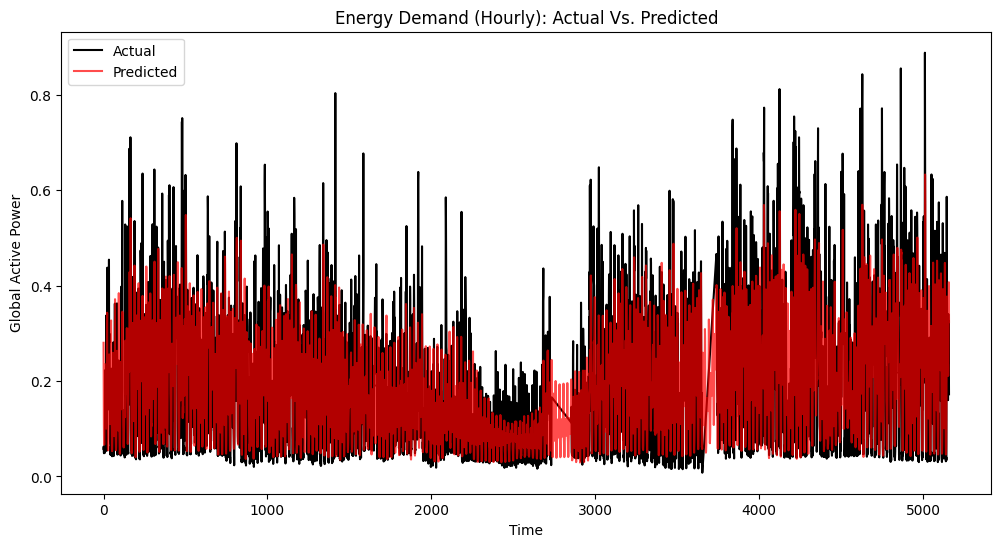

In [ ]:
plot_actual_vs_pred(y_hr_test, y_pred_hr, "Hourly")

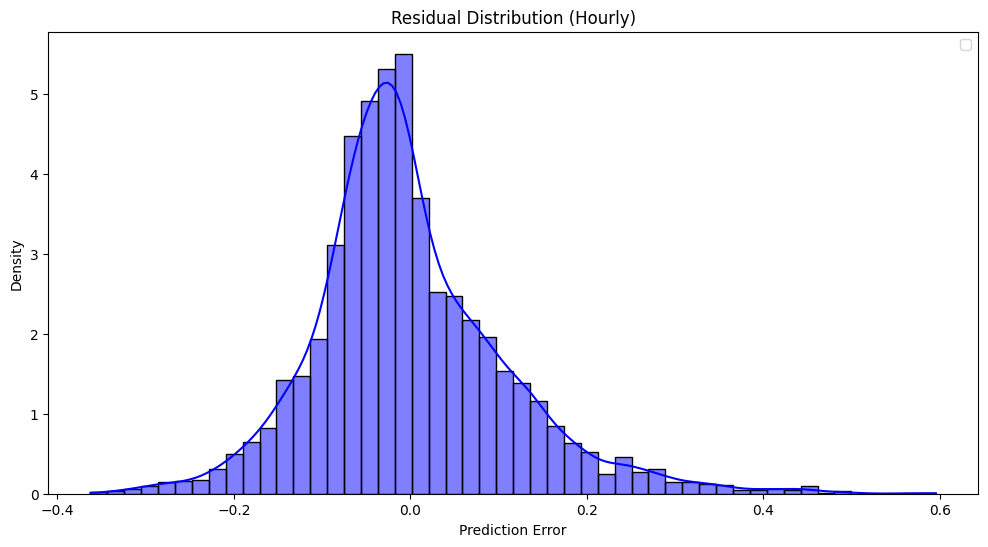

In [ ]:
plot_residuals(y_hr_test, y_pred_hr, "Hourly")

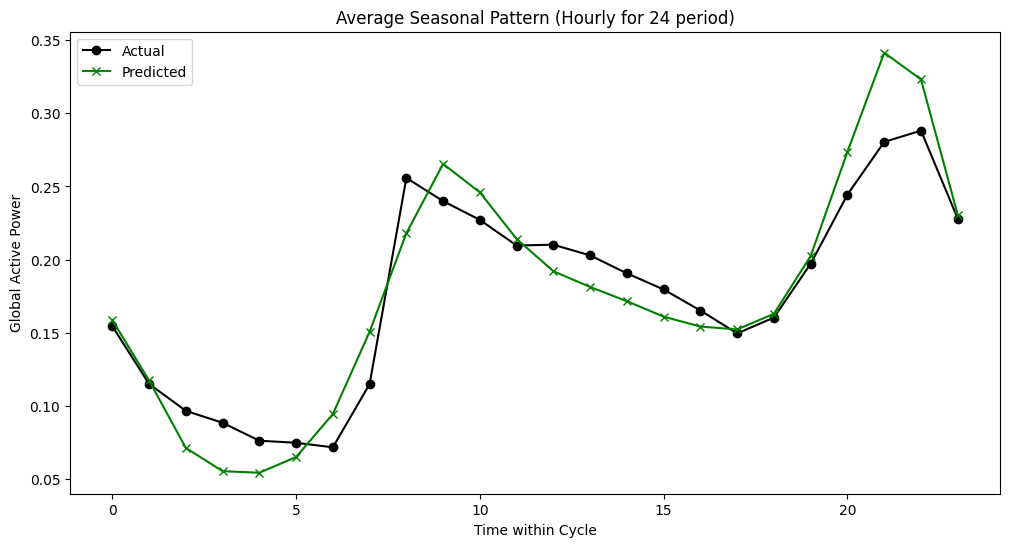

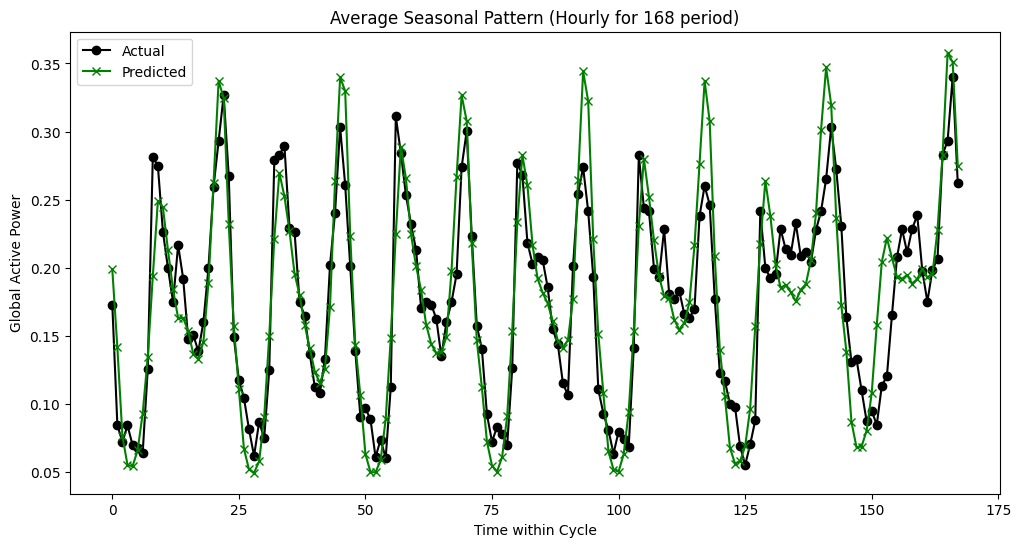

In [ ]:
plot_seasonal_patterns(y_hr_test, y_pred_hr, 24, "Hourly")
plot_seasonal_patterns(y_hr_test, y_pred_hr, 168, "Hourly")

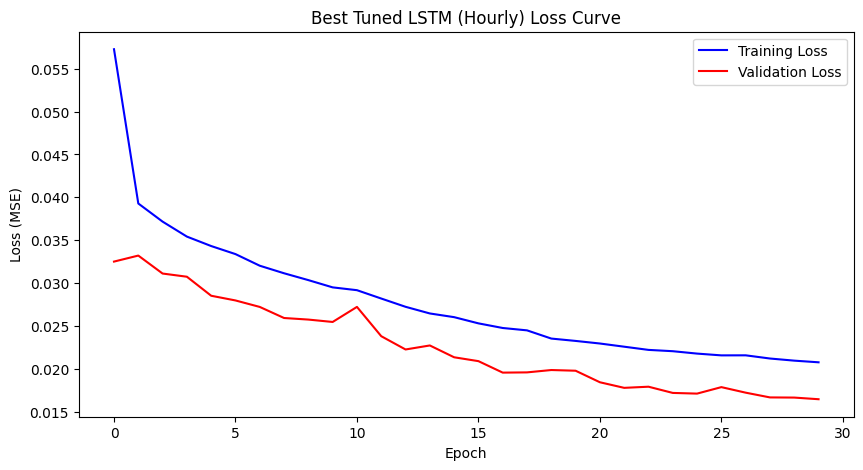

In [ ]:
best_model_hr1 = tuner_hourly.hypermodel.build(best_hps_hr)

history_hr = best_model_hr1.fit(
    X_hr_train, y_hr_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_hr_val, y_hr_val),
    callbacks=[early_stop],
    verbose=0
)

plot_loss_curve(history_hr, "Best Tuned LSTM", "Hourly")

Daily Data

In [ ]:
# instantiating tuner for daily data
tuner_daily = kt.RandomSearch(
    build_model1,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_tuning_daily'
)

In [ ]:
# running the search
tuner_daily.search(
    X_dy_train, y_dy_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dy_val, y_dy_val),
    callbacks=[early_stop]
)

Trial 15 Complete [00h 00m 15s]
val_loss: 0.010866856668144464

Best val_loss So Far: 0.009604571387171745
Total elapsed time: 00h 02m 56s


In [ ]:
best_hps_dy = tuner_daily.get_best_hyperparameters(num_trials=1)[0]
best_model_dy = tuner_daily.get_best_models(num_models=1)[0]

In [ ]:
print("Best Hyperparameters for Daily-level Data:")
print(best_hps_dy.values)
print("Best Model Summary:")
best_model_dy.summary()

Best Hyperparameters for Daily-level Data:
{'units_1': 192, 'units_2': 128, 'learning_rate': 0.001, 'dropout': 0.30000000000000004, 'model_type': 'simple'}
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 192)            │       166,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,849 (651.75 KB)

 Trainable params: 166,849 (651.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()
y_pred_dy = best_model_dy.predict(X_dy_test)
end_time = time.time()
dy_time = end_time - start_time

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
results_tuned.append(evaluate_model(y_dy_test, y_pred_dy, "Best Tuned LSTM", "Daily", dy_time))

Best Tuned LSTM (Daily) Evaluation: 
MSE  : 0.0192
MAE  : 0.1121
RMSE : 0.1387
R2   : -0.4596
Execution Time: 0.2312


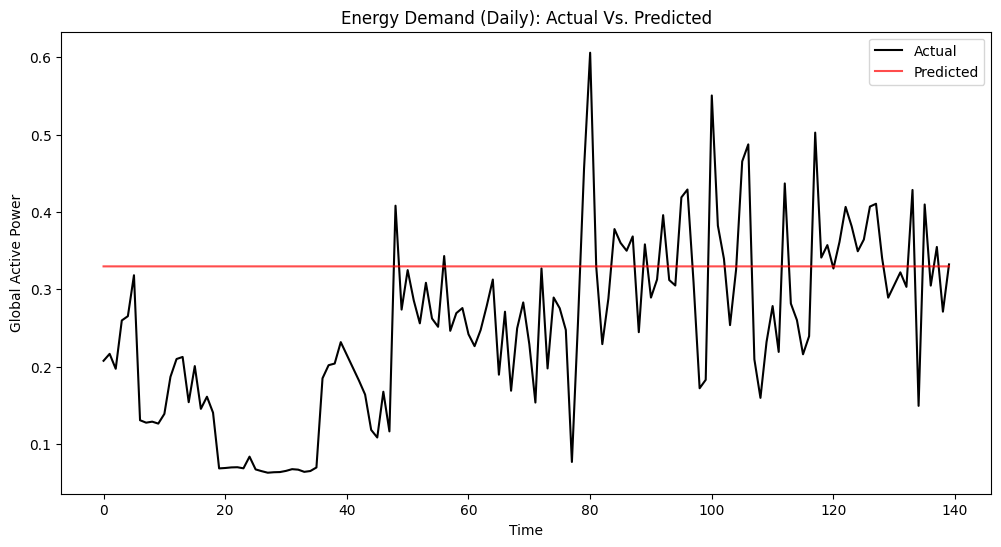

In [ ]:
plot_actual_vs_pred(y_dy_test, y_pred_dy, "Daily")

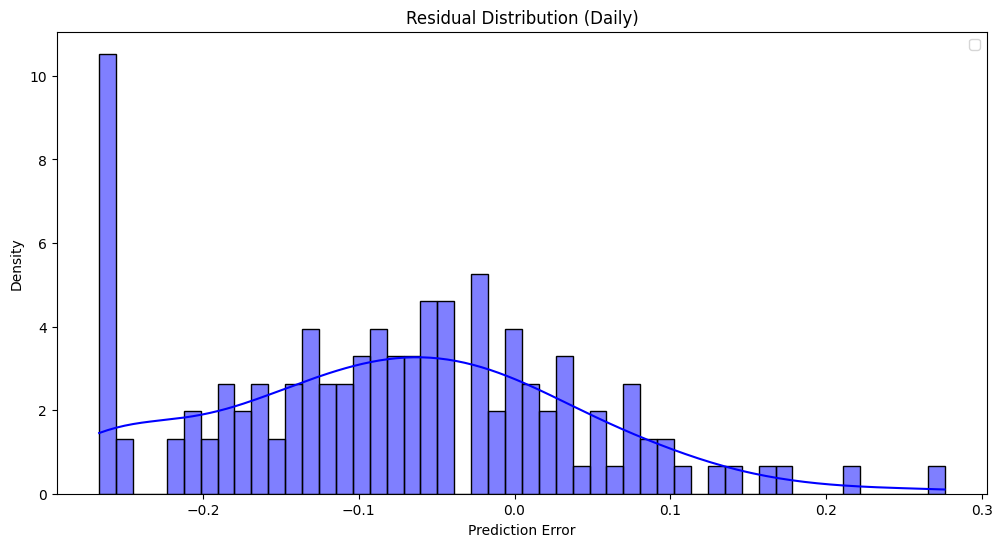

In [ ]:
plot_residuals(y_dy_test, y_pred_dy, "Daily")

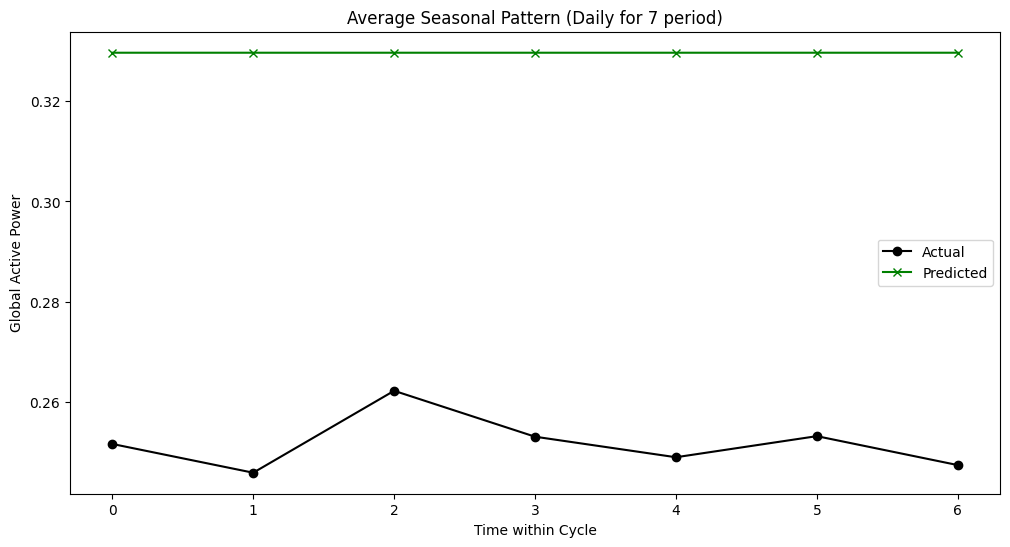

In [ ]:
plot_seasonal_patterns(y_dy_test, y_pred_dy, 7, "Daily")

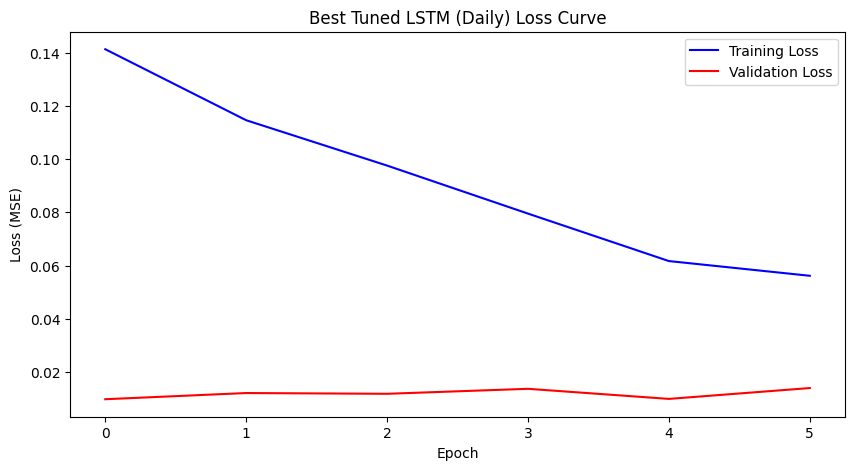

In [ ]:
best_model_dy1 = tuner_daily.hypermodel.build(best_hps_dy)

history_dy = best_model_dy1.fit(
    X_dy_train, y_dy_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dy_val, y_dy_val),
    callbacks=[early_stop],
    verbose=0
)

plot_loss_curve(history_dy, "Best Tuned LSTM", "Daily")

Comparison of metrics

In [ ]:
results_tuned_df = pd.DataFrame(results_tuned)
print("Comparison of the results of the tuned model performance: \n")
print(results_tuned_df)

Comparison of the results of the tuned model performance: 

             Model Frequency       MSE       MAE      RMSE  R2 Score  \
0  Best Tuned LSTM    Minute  0.001923  0.017555  0.043855  0.941030   
1  Best Tuned LSTM    Hourly  0.012002  0.081129  0.109555  0.446694   
2  Best Tuned LSTM     Daily  0.019234  0.112110  0.138686 -0.459582   

   Execution Time  
0       36.800991  
1        0.794486  
2        0.231185  


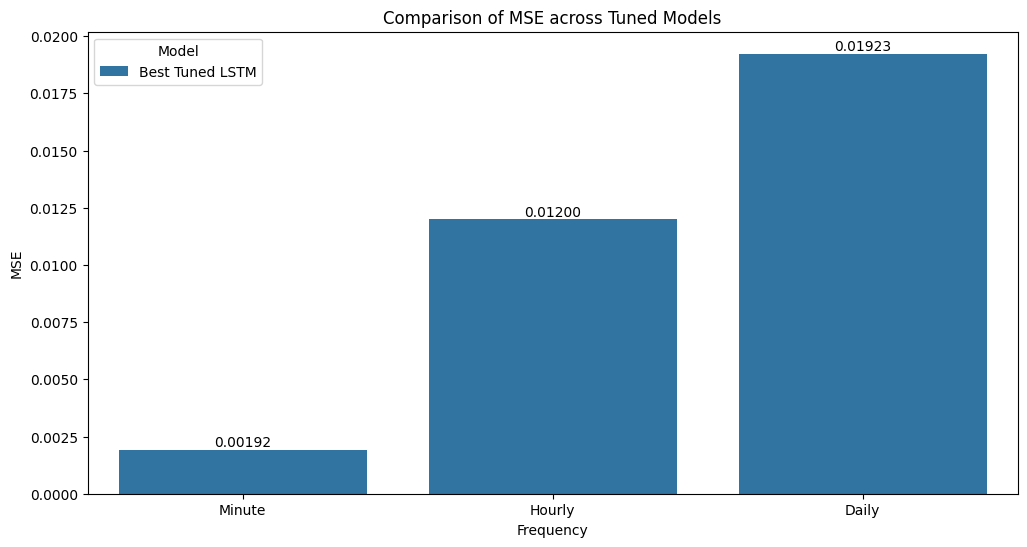

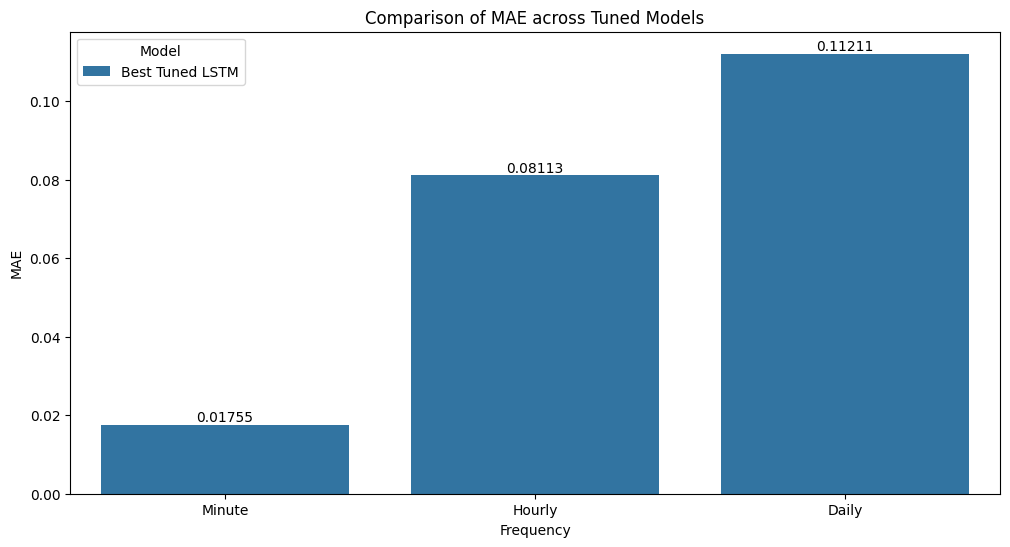

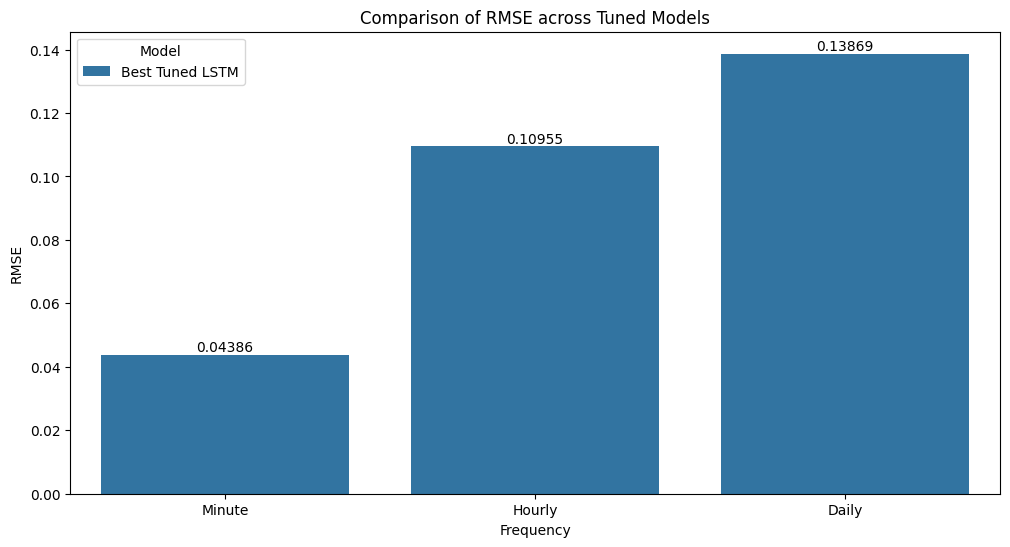

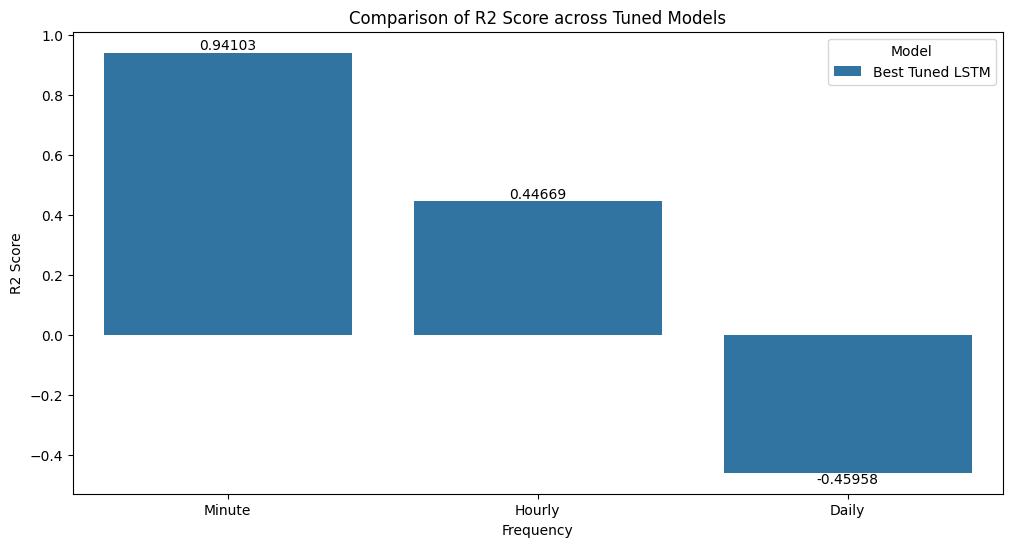

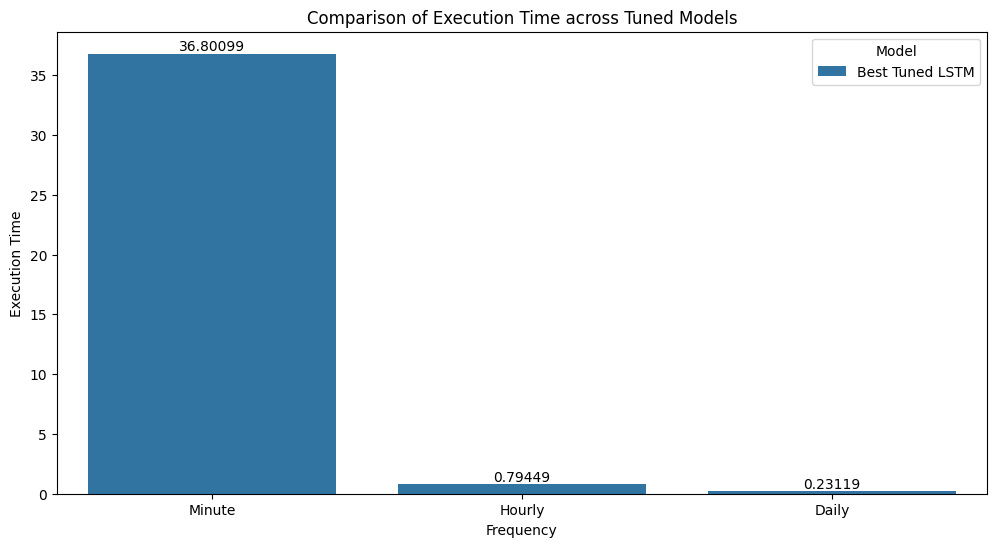

In [ ]:
metrics_col = ["MSE", "MAE", "RMSE", "R2 Score", "Execution Time"]
for col in metrics_col:
  plt.figure(figsize=(12, 6))
  ax = sns.barplot(data=results_tuned_df, x="Frequency", y=col, hue="Model")
  plt.title(f"Comparison of {col} across Tuned Models")
  plt.xlabel("Frequency")
  plt.ylabel(col)

  # Add values on top of the bars
  for container in ax.containers:
      ax.bar_label(container, fmt='%.5f')

  plt.show()